With respect to additional figures, what I think would be impressive is if, for all genes, you calculate dN/dS using the evolved data (maybe just using SNPs) and then plot it against the dN/dS that you produced for the Pf6K in the Mozambique study, which I know you already have (and which I can put into Genes by Taxon, if needed).  You might need to subset the data.  I would put this as an additional panel in Figure 4.  It would sort of look like the one below but I think would now have a negative correlation instead of positive. 

In [113]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib as mpl
import matplotlib
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 250
import pandas as pd
import itertools
import seaborn as sns
from Bio import SeqIO
import pickle
import copy
import random
from urllib.parse import unquote
from adjustText import adjust_text

In [114]:
# ============================
# Load genome information
# ============================
'''
fasta_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.fasta"

chromosome_sequence_dict = {}

for seq_record in SeqIO.parse(fasta_fpath, "fasta"):
    chrom = str(seq_record.id)
    sequence = str(seq_record.seq)
    chromosome_sequence_dict[chrom] = sequence
'''
# ============================
# Load gene information
# ============================

gff_fpath = "/storage/NFS/GENOME_RESOURCES/pf/p_fal_ref/p_fal.gff"

chromosomes = []
for line in open(gff_fpath, 'r'):
    if line[0] != '#':
        break
    if line[:17] == '##sequence-region':
        chromosomes.append(line.strip().split()[1])

nuclear_chromosomes = sorted(chromosomes[2:])
chrom_gene_exon_interval_dict = {chrom: defaultdict(dict) for chrom in chromosomes} # chrom -> gene ID -> exon ID -> (start, end, strand_direction)

chrom_gene_ids_dict = {chrom: set() for chrom in chromosomes} # All protein coding gene IDs
chrom_gene_desc_dict = {chrom: {} for chrom in chromosomes} # gene_id -> description
chrom_gene_interval_dict = {chrom: {} for chrom in chromosomes} # gene_id -> (start, end, strand_direction)

for line in open(gff_fpath, 'r'):
    if line.strip() == '##FASTA':
        break
    if line[0] == '#':
        continue
    chrom, source, feature_type, start_pos, end_pos, _, sdirection, _, info = line.strip().split('\t')
    start_pos = int(start_pos); end_pos = int(end_pos)
    if feature_type == 'exon':
        exon_id = info.split(';')[0].split('ID=')[1]
        gene_id = exon_id.split('exon_')[1].split('-')[0]
        chrom_gene_exon_interval_dict[chrom][gene_id][exon_id] = (start_pos, end_pos, sdirection)
    if feature_type == 'gene':
        gene_id = info.split(';')[0].split('ID=')[1]
        gene_desc = info.split(';')[2].split('description=')[1]
        chrom_gene_desc_dict[chrom][gene_id] = unquote(gene_desc.strip()).replace('+', ' ')
        chrom_gene_interval_dict[chrom][gene_id] = (start_pos, end_pos, sdirection)
    if feature_type == 'CDS': # Actually coding
        gene_id = info.split(';')[0].split('ID=')[1].split('cds_')[1].split('-')[0]
        if gene_id != 'PF3D7_0112400' and 'pseudogene' not in chrom_gene_desc_dict[chrom][gene_id]: # Ignore pseudogenes
            chrom_gene_ids_dict[chrom].add(gene_id)

big_gene_desc_dict = {}
for chrom in chrom_gene_desc_dict:
    for gene in chrom_gene_desc_dict[chrom]:
        big_gene = gene.split('.')[0]
        big_gene_desc_dict[big_gene] = chrom_gene_desc_dict[chrom][gene]

big_gene_desc_dict['PF3D7_1318600'] = 'thioredoxin'

big_gene_abbr_dict = {}
for gene in big_gene_desc_dict:
    desc = big_gene_desc_dict[gene]
    if '(' in desc:
        abbr = desc.split('(')[-1].split(')')[0]
        big_gene_abbr_dict[gene] = abbr

big_gene_abbr_dict['PF3D7_1318100'] = 'ferredoxin'
big_gene_abbr_dict['PF3D7_1318600'] = 'thioredoxin'

total_num_coding_genes = sum([len(chrom_gene_ids_dict[chrom]) for chrom in chromosomes])
alt_order_chromosomes = ['Pf3D7_01_v3', 'Pf3D7_06_v3', 'Pf3D7_11_v3', 'Pf3D7_02_v3', 'Pf3D7_07_v3', 'Pf3D7_12_v3', 
                         'Pf3D7_03_v3', 'Pf3D7_08_v3', 'Pf3D7_13_v3', 'Pf3D7_04_v3', 'Pf3D7_09_v3', 'Pf3D7_14_v3', 
                         'Pf3D7_05_v3', 'Pf3D7_10_v3', 'M76611', 'PFC10_API_IRAB']
for chrom_i in range(0, len(alt_order_chromosomes[:-2]), 3):
    print("\t".join(["%s\t%i" % (chrom, len(chrom_gene_ids_dict[chrom])) for chrom in alt_order_chromosomes[chrom_i:chrom_i+3]]))
print('\n' + "\t".join(["%s\t%i" % (chrom, len(chrom_gene_ids_dict[chrom])) for chrom in ['M76611', 'PFC10_API_IRAB']]) + '\n')
print("Total number of protein coding genes: %i" % total_num_coding_genes)

Pf3D7_01_v3	135	Pf3D7_06_v3	320	Pf3D7_11_v3	485
Pf3D7_02_v3	223	Pf3D7_07_v3	295	Pf3D7_12_v3	531
Pf3D7_03_v3	243	Pf3D7_08_v3	317	Pf3D7_13_v3	699
Pf3D7_04_v3	235	Pf3D7_09_v3	383	Pf3D7_14_v3	775
Pf3D7_05_v3	312	Pf3D7_10_v3	414	M76611	3

M76611	3	PFC10_API_IRAB	30

Total number of protein coding genes: 5400


In [115]:
for gene in big_gene_desc_dict:
    if 'ACS' in big_gene_desc_dict[gene]:
        print(gene, big_gene_desc_dict[gene])

PF3D7_0215000 acyl-CoA synthetase (ACS9)
PF3D7_0215300 acyl-CoA synthetase (ACS8)
PF3D7_0301000 acyl-CoA synthetase (ACS2)
PF3D7_0401900 acyl-CoA synthetase (ACS6)
PF3D7_0525100 acyl-CoA synthetase (ACS10)
PF3D7_0619500 acyl-CoA synthetase (ACS12)
PF3D7_0627800 acetyl-CoA synthetase, putative (ACS)
PF3D7_0731600 acyl-CoA synthetase (ACS5)
PF3D7_1200700 acyl-CoA synthetase (ACS7)
PF3D7_1238800 acyl-CoA synthetase (ACS11)
PF3D7_1253400 acyl-CoA synthetase (ACS3)
PF3D7_1372400 acyl-CoA synthetase (ACS4)
PF3D7_1477900 acyl-CoA synthetase, pseudogene (ACS1b)
PF3D7_1479000 acyl-CoA synthetase (ACS1a)


In [4]:
gene_id_chrom_dict = {}
for chrom in chrom_gene_ids_dict:
    for gene_id in chrom_gene_ids_dict[chrom]:
        gene_id_chrom_dict[gene_id] = chrom

In [5]:
# Real gene abbreviation dict from Genes by Taxon

gene_name_dict = {}
gene_desc_dict = {}

f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/Pf_gene_name_desc.tsv', 'r')
header = f.readline()
for line in f:
    gene_ID, gene_name, gene_desc = line.strip().split('\t')
    if gene_name != '':
        gene_name_dict[gene_ID] = gene_name
    if gene_desc != '':
        gene_desc_dict[gene_ID] = gene_desc

In [6]:
# ============================
# Load expected N/S
# ============================

gene_expn_exps_dict = defaultdict(dict)

f = open("/storage/NFS/ROTATION_PROJECT/daisy/dnds/pfal_expected_ns_s.csv", 'r')
header = f.readline()
for line in f:
    chrom, gene_id, expn, exps = line.strip().split(',')
    expn = float(expn); exps = float(exps)
    gene_expn_exps_dict[chrom][gene_id] = (float(expn), float(exps))

f.close()

big_gene_expn_exps_dict = {}
for chrom in gene_expn_exps_dict:
    for gene in gene_expn_exps_dict[chrom]:
        big_gene = gene.split('.')[0]
        big_gene_expn_exps_dict[big_gene] = gene_expn_exps_dict[chrom][gene]

In [7]:
# Pf6 metadata

# Sample metadata

f = open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/File2_Pf_6_samples.txt', 'r')
header = f.readline().split('\t')

pf6_samples = []
sample_country_dict = {}
country_samples_dict = defaultdict(list)
sample_site_dict = {}
sample_year_dict = {}
sample_qc_pass_dict = {}

for line in f:
    items = line.strip().split('\t')
    sample, study, site, country, lat, long, year, ena, sameind, pop, pctcall, qc, _, _ = items
    year = int(year) if items[6] != 'Lab' else 'Lab'
    
    pf6_samples.append(sample)
    sample_country_dict[sample] = country
    country_samples_dict[country].append(sample)
    sample_site_dict[sample] = site
    sample_year_dict[sample] = year
    sample_qc_pass_dict[sample] = True if qc == 'True' else False

pf6_good_samples = []
for sample in pf6_samples:
    if sample_qc_pass_dict[sample]:
        pf6_good_samples.append(sample)

print("%i Pf6 samples, %i good" % (len(pf6_samples), len(pf6_good_samples)))
all_good_samples = pf6_good_samples

country_region_dict = {}
country_region_dict['Bangladesh'] = 'Southeast Asia'
country_region_dict['Benin'] = 'Africa'
country_region_dict['Burkina Faso'] = 'Africa'
country_region_dict['Cambodia'] = 'Southeast Asia'
country_region_dict['Cameroon'] = 'Africa'
country_region_dict['Colombia'] = 'South America'
country_region_dict['Congo DR'] = 'Africa'
country_region_dict['Ethiopia'] = 'Africa'
country_region_dict['Gambia'] = 'Africa'
country_region_dict['Ghana'] = 'Africa'
country_region_dict['Guinea'] = 'Africa'
country_region_dict['Indonesia'] = 'Southeast Asia'
country_region_dict['Ivory Coast'] = 'Africa'
country_region_dict['Kenya'] = 'Africa'
country_region_dict['Lab'] = 'Unknown'
country_region_dict['Laos'] = 'Southeast Asia'
country_region_dict['Madagascar'] = 'Africa'
country_region_dict['Malawi'] = 'Africa'
country_region_dict['Mali'] = 'Africa'
country_region_dict['Mauritania'] = 'Africa'
country_region_dict['Mozambique'] = 'Africa'
country_region_dict['Myanmar'] = 'Southeast Asia'
country_region_dict['Nigeria'] = 'Africa'
country_region_dict['Papua New Guinea'] = 'Oceania'
country_region_dict['Peru'] = 'South America'
country_region_dict['Senegal'] = 'Africa'
country_region_dict['Tanzania'] = 'Africa'
country_region_dict['Thailand'] = 'Southeast Asia'
country_region_dict['Uganda'] = 'Africa'
country_region_dict['Viet Nam'] = 'Southeast Asia'

7113 Pf6 samples, 5970 good


In [8]:
dnds_pickle_dir = "/storage/NFS/ROTATION_PROJECT/daisy/dnds/pickles"
sample_gene_ns_s_dict = pickle.load(open("%s/pf6_moz_sample_gene_ns_s_dict.pkl" % (dnds_pickle_dir), 'rb'))

In [39]:
chrom_pos_ref_dict = defaultdict(dict)
gene_snv_effect_dict = defaultdict(dict)
gene_snv_codon_change_dict = defaultdict(dict)
gene_snv_impact_dict = defaultdict(dict)
gene_snv_aa_change_dict = defaultdict(dict)

In [10]:
# Get SNV data from Masterfile

f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/SNP_INDEL_Masterfile_10-20-2022.tsv', 'r')
header = f.readline().strip().split('\t')

master_clone_set = set()
master_clone_compound_dict = {}
master_clone_strain_dict = {}

evolved_gene_ns_snvs_dict = defaultdict(set) # gene -> (pos, alt)
evolved_gene_ns_snv_count_dict = {}
evolved_gene_ns_snv_compounds_dict = {}
evolved_gene_s_snvs_dict = defaultdict(set) # gene -> (pos, alt)
evolved_gene_s_snv_count_dict = {}
evolved_gene_s_snv_compounds_dict = {}
evolved_all_genes = set()

total_mutation_count = 0

for line in f:
    items = line.rstrip('\n').split('\t')
    clone_name, compound, perm, IP, fold_shift, strain, lab, chrom, pos, varID, \
        mutation_rank, independent, independentEW, gene_ID, gene_desc, quality, ref, alt, \
        vartype, effect, impact, codon_change, aa_change, status, genome_class = items[:25]
    # if perm != 'No':
    clone_name = clone_name.strip()
    master_clone_set.add(clone_name)
    master_clone_compound_dict[clone_name] = compound
    master_clone_strain_dict[clone_name] = strain
    
    if pos == 'no mutations':
        continue
    
    total_mutation_count += 1
    
    if 'n' in independent.lower() or 'n' in independentEW.lower() or mutation_rank == 'Secondary': # Skip if not independent
        continue
    elif ('y' in independent.lower() or 'y' in independentEW.lower()) and mutation_rank == 'Primary':
        pass
    else:
        continue
    
    pos = int(pos); gene_ID = gene_ID.strip().split('.')[0]
    
    if gene_ID != '' and vartype == 'SNP':
        
        chrom_pos_ref_dict[chrom][pos] = ref
        gene_snv_effect_dict[gene_ID][(pos, alt)] = effect
        gene_snv_codon_change_dict[gene_ID][(pos, alt)] = codon_change
        gene_snv_impact_dict[gene_ID][(pos, alt)] = impact
        gene_snv_aa_change_dict[gene_ID][(pos, alt)] = aa_change
        
        if impact in ['MISSENSE', 'NONSENSE']:
            evolved_gene_ns_snvs_dict[gene_ID].add((pos, alt))
            if gene_ID not in evolved_gene_ns_snv_count_dict:
                evolved_gene_ns_snv_count_dict[gene_ID] = defaultdict(int)
                evolved_gene_ns_snv_compounds_dict[gene_ID] = defaultdict(set)
            evolved_gene_ns_snv_count_dict[gene_ID][(pos, alt)] += 1
            evolved_gene_ns_snv_compounds_dict[gene_ID][(pos, alt)].add(compound)
            evolved_all_genes.add(gene_ID)
        elif impact in ['SILENT']:
            evolved_gene_s_snvs_dict[gene_ID].add((pos, alt))
            if gene_ID not in evolved_gene_s_snv_count_dict:
                evolved_gene_s_snv_count_dict[gene_ID] = defaultdict(int)
                evolved_gene_s_snv_compounds_dict[gene_ID] = defaultdict(set)
            evolved_gene_s_snv_count_dict[gene_ID][(pos, alt)] += 1
            evolved_gene_s_snv_compounds_dict[gene_ID][(pos, alt)].add(compound)
            evolved_all_genes.add(gene_ID)

print("%i clones" % len(master_clone_set))
print("%i total mutations" % total_mutation_count)
print("%i nonsynonymous, %i synonymous SNVs" % (sum([len(evolved_gene_ns_snvs_dict[g]) for g in evolved_gene_ns_snvs_dict]),
                                                sum([len(evolved_gene_s_snvs_dict[g]) for g in evolved_gene_s_snvs_dict])))
print("in %i genes" % len(evolved_all_genes))

727 clones
5560 total mutations
751 nonsynonymous, 151 synonymous SNVs
in 619 genes


In [11]:
pdr5_mutations = ['A284V', 'S539L', 'M540I', 'T550N', 'T552A', 'T552I', 'F622I', 'F683L', 'A684S', 'S694A', 'V741L', 'W698L', 
                  'F715Y', 'A723V', 'V726F', 'A747D', 'G750D', 'Y764S', 'T1045N', 'Q1235E', 'Q1237R', 'G1297C', 'F1310Y', 
                  'T1364S', 'M1379V', 'M1373T', 'P1376T', 'A1378S', 'P1380R', 'W1383L', 'Y1414N', 'G1441C']
cdr1_mutations = ['N535I', 'T540I', 'S542L', 'S542P', 'Y544F', 'R546Y', 'R546T', 'G547R', 'C712S',
                  'A713P', 'Q714P', 'F1235C', 'N1240D', 'W1295S', 'V1322G', 'V1322A', 'Q1388P']
pdr5_mutation_pos = [int(x[1:-1]) for x in pdr5_mutations]
cdr1_mutation_pos = [int(x[1:-1]) for x in cdr1_mutations]

In [12]:
print(sorted(pdr5_mutation_pos))
print(sorted(cdr1_mutation_pos))

[284, 539, 540, 550, 552, 552, 622, 683, 684, 694, 698, 715, 723, 726, 741, 747, 750, 764, 1045, 1235, 1237, 1297, 1310, 1364, 1373, 1376, 1378, 1379, 1380, 1383, 1414, 1441]
[535, 540, 542, 542, 544, 546, 546, 547, 712, 713, 714, 1235, 1240, 1295, 1322, 1322, 1388]


In [13]:
for pos, alt in evolved_gene_ns_snvs_dict['PF3D7_0523000']:
    print(gene_snv_aa_change_dict['PF3D7_0523000'][(pos, alt)])

p.Gly88Asp/c.263G>A
p.Met841Ile/c.2523G>A
p.Phe1072Leu/c.3216T>A
p.Phe78Leu/c.232T>C
p.Ser76Phe/c.227C>T
p.Thr1073Ile/c.3218C>T
p.Leu917Phe/c.2749C>T
p.Phe928Leu/c.2784T>G
p.Gly293Val/c.878G>T
p.Ala807Thr/c.2419G>A
p.Gly88Ser/c.262G>A
p.Tyr290Phe/c.869A>T
p.Ser1075Ile/c.3224G>T
p.Asn1042Ile/c.3125A>T
p.Phe806Leu/c.2418T>G
p.Ile205Phe/c.613A>T
p.Gly316Arg/c.946G>C
p.Gly293Cys/c.877G>T
p.Met841Ile/c.2523G>T


# Supplemental Table 7

In [260]:
def aa_change_to_tup(aa_change):
    inter_aa_change = aa_change.lstrip('p.')
    aa = inter_aa_change[:3]
    pos = ''
    for char in inter_aa_change[3:]:
        if char not in '1234567890':
            break
        pos += char
    pos = int(pos)
    return aa, pos

gene_plotted_pos_dict = {
    'PF3D7_0321900': [923089, 923125, 923143, 923160, 923169, 923909, 923916, 923974, 923982, 924128, 924554, 924757, 924807, 
                      924825, 925105, 925194, 925275, 925292, 925302, 925439, 925946, 925967, 926076],
    'PF3D7_0523000': [958145, 958277, 958320, 958440, 958584, 959099, 959168, 959183, 959364, 959401, 960137, 960240, 960702, 
                      960792, 960816, 960989, 961013, 961214, 961566, 961625],
    'PF3D7_1211900': [529091, 529134, 529187, 529346, 529418, 529453, 529457, 529477, 529487, 529559, 529709, 529835, 530393, 
                      530705, 530975, 531011, 532010, 532112, 532133, 532208, 532718],
    'mal_mito_3': [3762, 3795, 3797, 3831, 4426, 4539, 4543, 4552, 4582]}

In [262]:
featured_genes = []
for gene in gene_name_dict:
    if gene_name_dict[gene] in ['MDR1', 'ATP4', 'CARL']:# or gene in ['PF3D7_1036800', 'PF3D7_1113300']:
        chrom_num = gene[6:8]
        chrom = 'Pf3D7_%s_v3' % chrom_num
        print(gene, gene_name_dict[gene], chrom_gene_interval_dict[chrom][gene])
        featured_genes.append(gene)

chrom = 'M76611'
for gene in big_gene_desc_dict:
    if big_gene_desc_dict[gene] == 'cytochrome b (CYTB)':
        print(gene, big_gene_desc_dict[gene], chrom_gene_interval_dict[chrom][gene])
        featured_genes.append(gene)

PF3D7_0321900 CARL (922974, 927942, '+')
PF3D7_0523000 MDR1 (957890, 962149, '+')
PF3D7_1211900 ATP4 (529005, 532799, '-')
mal_mito_3 cytochrome b (CYTB) (3492, 4622, '+')


In [276]:
import gzip
vcf_file = gzip.open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf_60_public_Pf3D7_01_v3.final.vcf.gz', 'rt')
samples = []
for line in vcf_file:
    if line[:6] == '#CHROM':
        samples = line.split('\t')[9:]
    if line[:2] != '##':
        break
print("Number of samples: %i" % len(samples))

gene_snv_sample_data_dict = {gene: defaultdict(dict) for gene in featured_genes} # snv -> sample -> data
gene_snv_samples_dict = {gene: defaultdict(set) for gene in featured_genes} # snv -> samples
gene_snv_samples_relaxed_dict = {gene: defaultdict(set) for gene in featured_genes} # snv -> samples
gene_snv_alt_depth_dict = {gene: defaultdict(int) for gene in featured_genes}
gene_snv_total_depth_dict = {gene: defaultdict(int) for gene in featured_genes}
gene_snv_anno_dict = {gene: {} for gene in featured_genes} # snv -> data tuple

store_ADs = []

for gene in tqdm(featured_genes):
    f = open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf6-%s.ann.txt' % gene, 'r')
    for line in f:
        items = line.strip().split('\t')
        CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]
        alleles = [REF] + ALT.split(',')
        POS = int(POS)
        
        if POS in [530436, 530657, 531553] and CHROM == 'Pf3D7_12_v3':
            print(items[:9])
        
        if REF not in ['A', 'C', 'G', 'T']:
            continue
        
        chrom_pos_ref_dict[CHROM][POS] = REF
        
        for tup, sample in zip(items[9:], samples): # FORMAT is GT:AD:DP:PGT:PID
            GT, AD, DP = tup.split(':')[:3]
            if DP == '.':
                continue
            
            if POS == 530657 and CHROM == 'Pf3D7_12_v3':
                store_ADs.append(AD)
            
            depths = [int(depth) for depth in AD.split(',')]
            total_depth = sum(depths)
            
            for alt_allele, alt_depth in zip(ALT.split(','), depths[1:]):                
                if alt_allele in ['A', 'C', 'G', 'T']:
                    gene_snv_sample_data_dict[gene][(POS, alt_allele)][sample] = (GT, AD)
                    gene_snv_alt_depth_dict[gene][(POS, alt_allele)] += alt_depth
                    gene_snv_total_depth_dict[gene][(POS, alt_allele)] += total_depth
                    if total_depth >= 50 and alt_depth/float(total_depth) >= 0.5:
                        gene_snv_samples_dict[gene][(POS, alt_allele)].add(sample)
                    if alt_depth > 0 and alt_depth/float(total_depth) >= 0.5:
                        gene_snv_samples_relaxed_dict[gene][(POS, alt_allele)].add(sample)
        
        pre_eff = INFO.split(';EFF=')[0]
        eff = INFO.split(';EFF=')[1].split(';')[0]
        
        for anno in eff.split(','):
            alt_allele = anno.split('|')[-1].split(')')[0]
            effect, rest = anno.split('(')
            impact, codon_change, aa_change = rest.split('|')[1:4]
            gene_snv_effect_dict[gene][(POS, alt_allele)] = effect
            gene_snv_codon_change_dict[gene][(POS, alt_allele)] = codon_change
            gene_snv_impact_dict[gene][(POS, alt_allele)] = impact
            if effect == 'missense_variant':
                gene_snv_aa_change_dict[gene][(POS, alt_allele)] = aa_change.split('/')[0]
            

Number of samples: 7113


 50%|█████████████████████████████████████████▌                                         | 2/4 [00:32<00:31, 15.64s/it]

['Pf3D7_12_v3', '530657', '.', 'G', 'T', '1667.34', 'PASS', 'AC=2;AN=13870;DP=577864;RegionType=Core;SNPEFF_AMINO_ACID_CHANGE=Q715K;SNPEFF_CODON_CHANGE=Caa/Aaa;SNPEFF_EFFECT=NON_SYNONYMOUS_CODING;SNPEFF_EXON_ID=1;SNPEFF_FUNCTIONAL_CLASS=MISSENSE;SNPEFF_GENE_NAME=ATP4;SNPEFF_IMPACT=MODERATE;SNPEFF_TRANSCRIPT_ID=PF3D7_1211900.1;VQSLOD=0.168;CDS;EFF=missense_variant(MODERATE|MISSENSE|Caa/Aaa|p.Gln715Lys/c.2143C>A|1264|PF3D7_1211900|protein_coding|CODING|rna_PF3D7_1211900-1|1|T)', 'GT:AD:DP:PGT:PID']


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.85s/it]


In [284]:
# Very low frequency mutation (530657 Pf3D7_12_v3 T)
for AD in store_ADs:
    depths = [int(d) for d in AD.split(',')]
    if sum(depths[1:]) > 0:
        print(AD)

5,1
63,64


In [285]:
for snv in gene_snv_alt_depth_dict['PF3D7_1211900']:
    if 530657 in snv:
        print(snv)

(530657, 'T')


In [264]:
gene_snv_maf_dict = defaultdict(dict)
for gene in gene_snv_alt_depth_dict:
    for snv in gene_snv_alt_depth_dict[gene]:
        alt_depth = gene_snv_alt_depth_dict[gene][snv]
        total_depth = gene_snv_total_depth_dict[gene][snv]
        gene_snv_maf_dict[gene][snv] = alt_depth/float(total_depth)

In [265]:
all_gene_pos_alt_tups = set()

evolved_gene_pos_alt_tups = set()
for gene in featured_genes:
    for pos, alt in evolved_gene_ns_snv_count_dict[gene]:
        evolved_gene_pos_alt_tups.add((gene, pos, alt))
        all_gene_pos_alt_tups.add((gene, pos, alt))
for gene in featured_genes:
    if gene in evolved_gene_s_snv_count_dict:
        for pos, alt in evolved_gene_s_snv_count_dict[gene]:
            evolved_gene_pos_alt_tups.add((gene, pos, alt))
            all_gene_pos_alt_tups.add((gene, pos, alt))

for gene in featured_genes:
    for pos, alt in gene_snv_maf_dict[gene]: # gene_snv_samples_dict[gene]:
        all_gene_pos_alt_tups.add((gene, pos, alt))
        '''
        good_samples = set()
        for sample in samples: # all_good_samples:
            if sample in gene_snv_samples_dict[gene][(pos, alt)]:
                good_samples.add(sample)
        if len(good_samples) > 1:
            all_gene_pos_alt_tups.add((gene, pos, alt))
        '''

print(len(all_gene_pos_alt_tups))

2655


In [19]:
# Write table (SNVs only!)
# Exclude singletons (both singleton/absent in Pf6 and evolved)

gene_plotted_in_table_pos_dict = defaultdict(set)
test_gene_aa_pos_tups = set()

gene_filtered_snv_dict = defaultdict(list)

f = open("/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/SupplementaryData7_Featured_SNVs_08092023.tsv", 'w')
header_items = ['Gene ID', 'Gene Name', 'Chromosome', 'Position', 'Ref Base', 'Alt Base',
                'Effect', 'Impact', 'Codon Change', 'Amino Acid Change', 
                'Number of independent mutations', 'Compound selections', 
                'Pf6 AF', 'Number of Pf6 samples', 'Pf6 countries', 'Pf6 Plotted']
f.write('\t'.join(header_items) + '\n')
for gene, pos, alt in sorted(all_gene_pos_alt_tups):
    gene_name = 'CYTB' if gene == 'mal_mito_3' else gene_name_dict[gene]
    chrom = 'M76611' if gene == 'mal_mito_3' else 'Pf3D7_%s_v3' % gene[6:8]
    ref = chrom_pos_ref_dict[chrom][pos]
    effect = gene_snv_effect_dict[gene][(pos, alt)]
    codon_change = gene_snv_codon_change_dict[gene][(pos, alt)]
    impact = gene_snv_impact_dict[gene][(pos, alt)]
    aa_change = gene_snv_aa_change_dict[gene][(pos, alt)]
    
    if (pos, alt) in evolved_gene_ns_snv_count_dict[gene]:
        evolved_count = evolved_gene_ns_snv_count_dict[gene][(pos, alt)]
        evolved_compounds = ','.join(sorted(evolved_gene_ns_snv_compounds_dict[gene][(pos, alt)]))
    elif gene in evolved_gene_s_snv_count_dict and (pos, alt) in evolved_gene_s_snv_count_dict[gene]:
        evolved_count = evolved_gene_ns_snv_count_dict[gene][(pos, alt)]
        evolved_compounds = ','.join(sorted(evolved_gene_s_snv_compounds_dict[gene][(pos, alt)]))
    else:
        evolved_count = 0
        evolved_compounds = ''
    
    pf6_maf = gene_snv_maf_dict[gene][(pos, alt)] if (pos, alt) in gene_snv_maf_dict[gene] else 0
    pf6_samples = gene_snv_samples_dict[gene][(pos, alt)]
    pf6_count = len(pf6_samples)
    pf6_countries = set()
    for sample in pf6_samples:
        pf6_countries.add(sample_country_dict[sample.strip()])
    pf6_countries = ','.join(sorted(pf6_countries))
    
    plotted = (pos in gene_plotted_pos_dict[gene])
    if plotted:
        gene_plotted_in_table_pos_dict[gene].add(pos)
    
    # Filtering step
    if pf6_count > 0 and pf6_maf > 0.002:        
        items = [gene, gene_name, chrom, pos, ref, alt, effect, impact, codon_change, aa_change,
                 evolved_count, evolved_compounds, pf6_maf, pf6_count, pf6_countries, plotted]
        f.write('\t'.join([str(item) for item in items]) + '\n')
        
        gene_filtered_snv_dict[gene].append((pos, alt))
        
        if impact == 'MISSENSE':
            aa, pos = aa_change_to_tup(aa_change)
            test_gene_aa_pos_tups.add((gene_name, aa, pos))

f.close()

# ATP4 validation variants

In [271]:
mutations_of_interest = [tup.split('\t') for tup in '''PF3D7_1036800	Pf3D7_10_v3	1449581	G	T
PF3D7_1036800	Pf3D7_10_v3	1449646	G	A
PF3D7_1113300	Pf3D7_11_v3	519223	G	C
PF3D7_1113300	Pf3D7_11_v3	519466	G	A
PF3D7_1113300	Pf3D7_11_v3	519469	G	C
PF3D7_1113300	Pf3D7_11_v3	519984	G	A'''.split('\n')]

mutations_of_interest = [tup.split('\t') for tup in '''PF3D7_1211900	Pf3D7_12_v3	529364	C	T
PF3D7_1211900	Pf3D7_12_v3	529418	C	T
PF3D7_1211900	Pf3D7_12_v3	529559	G	T
PF3D7_1211900	Pf3D7_12_v3	529665	A	C
PF3D7_1211900	Pf3D7_12_v3	529709	C	T
PF3D7_1211900	Pf3D7_12_v3	529835	G	C
PF3D7_1211900	Pf3D7_12_v3	530436	T	C
PF3D7_1211900	Pf3D7_12_v3	530657	G	C
PF3D7_1211900	Pf3D7_12_v3	531280	G	C
PF3D7_1211900	Pf3D7_12_v3	531553	G	T
PF3D7_1211900	Pf3D7_12_v3	532113	A	T
PF3D7_1211900	Pf3D7_12_v3	532131	G	T
PF3D7_1211900	Pf3D7_12_v3	532133	C	T'''.split('\n')]

atp4_snvs_of_interest = [(int(pos), alt) for gene, chrom, pos, ref, alt in mutations_of_interest]

In [289]:
for snv in atp4_snvs_of_interest:
    # print(snv)
    # print(gene_snv_maf_dict['PF3D7_1211900'][snv] if snv in gene_snv_maf_dict['PF3D7_1211900'] else 0)
    pf6_samples = gene_snv_samples_dict['PF3D7_1211900'][snv]
    pf6_count = len(pf6_samples)
    print(pf6_count)

5
2539
1568
181
70
16
0
0
48
0
370
1711
441


# TopoI investigations

In [198]:
import gzip
vcf_file = gzip.open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf_60_public_Pf3D7_01_v3.final.vcf.gz', 'rt')
samples = []
for line in vcf_file:
    if line[:6] == '#CHROM':
        samples = line.split('\t')[9:]
    if line[:2] != '##':
        break
print("Number of samples: %i" % len(samples))

Number of samples: 7113


In [200]:
featured_genes = ['PF3D7_0510500']

gene_snv_syn_aa_change_dict = defaultdict(dict)
gene_snv_mis_aa_change_dict = defaultdict(dict)

gene_snv_sample_data_dict = {gene: defaultdict(dict) for gene in featured_genes} # snv -> sample -> data
gene_snv_samples_dict = {gene: defaultdict(set) for gene in featured_genes} # snv -> samples
gene_snv_samples_relaxed_dict = {gene: defaultdict(set) for gene in featured_genes} # snv -> samples
gene_snv_alt_depth_dict = {gene: defaultdict(int) for gene in featured_genes}
gene_snv_total_depth_dict = {gene: defaultdict(int) for gene in featured_genes}
gene_snv_anno_dict = {gene: {} for gene in featured_genes} # snv -> data tuple

for gene in tqdm(featured_genes):
    f = open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf6-%s.ann.txt' % gene, 'r')
    for line in f:
        items = line.strip().split('\t')
        CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]
        alleles = [REF] + ALT.split(',')
        POS = int(POS)
        
        if REF not in ['A', 'C', 'G', 'T']:
            continue
        
        chrom_pos_ref_dict[CHROM][POS] = REF
        for tup, sample in zip(items[9:], samples): # FORMAT is GT:AD:DP:PGT:PID
            GT, AD, DP = tup.split(':')[:3]
            if DP == '.':
                continue
            
            depths = [int(depth) for depth in AD.split(',')]
            total_depth = sum(depths)
            
            for alt_allele, alt_depth in zip(ALT.split(','), depths[1:]):                
                if alt_allele in ['A', 'C', 'G', 'T']:
                    gene_snv_sample_data_dict[gene][(POS, alt_allele)][sample] = (GT, AD)
                    gene_snv_alt_depth_dict[gene][(POS, alt_allele)] += alt_depth
                    gene_snv_total_depth_dict[gene][(POS, alt_allele)] += total_depth
                    if total_depth >= 50 and alt_depth/float(total_depth) >= 0.5:
                        gene_snv_samples_dict[gene][(POS, alt_allele)].add(sample)
                    if alt_depth > 0 and alt_depth/float(total_depth) >= 0.5:
                        gene_snv_samples_relaxed_dict[gene][(POS, alt_allele)].add(sample)
        
        pre_eff = INFO.split(';EFF=')[0]
        eff = INFO.split(';EFF=')[1].split(';')[0]
        
        for anno in eff.split(','):
            alt_allele = anno.split('|')[-1].split(')')[0]
            effect, rest = anno.split('(')
            impact, codon_change, aa_change = rest.split('|')[1:4]
            gene_snv_effect_dict[gene][(POS, alt_allele)] = effect
            gene_snv_codon_change_dict[gene][(POS, alt_allele)] = codon_change
            gene_snv_impact_dict[gene][(POS, alt_allele)] = impact
            if effect == 'missense_variant':
                gene_snv_mis_aa_change_dict[gene][(POS, alt_allele)] = aa_change.split('/')[0]
            elif effect == 'synonymous_variant':
                gene_snv_syn_aa_change_dict[gene][(POS, alt_allele)] = aa_change.split('/')[0]

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


In [237]:
def aaf_to_bin(AAF):
    if AAF <= 0:
        return 0
    elif AAF < 0.8:
        return 1
    else:
        return 2

gene = 'PF3D7_0510500'
regions = ['South America', 'Africa', 'Southeast Asia', 'Oceania']
countries = ['Bangladesh', 'Benin', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Colombia', 'Congo DR', 'Ethiopia', 'Gambia', 
             'Ghana', 'Guinea', 'Indonesia', 'Ivory Coast', 'Kenya', 'Laos', 'Madagascar', 'Malawi', 'Mali', 
             'Mauritania', 'Mozambique', 'Myanmar', 'Nigeria', 'Papua New Guinea', 'Peru', 'Senegal', 'Tanzania', 'Thailand', 
             'Uganda', 'Viet Nam']

aa_changes_of_interest = set(gene_snv_mis_aa_change_dict[gene].values()).union(set(gene_snv_syn_aa_change_dict[gene].values()))

mutation_region_sample_aaf_bin_dict = {aa_change: {region: defaultdict(int) for region in regions} for aa_change in aa_changes_of_interest}
mutation_region_sample_GT_dict = {aa_change: {region: defaultdict(int) for region in regions} for aa_change in aa_changes_of_interest}
mutation_country_sample_GT_dict = {aa_change: {country: defaultdict(int) for country in countries} for aa_change in aa_changes_of_interest}
mutation_samples_dict = defaultdict(set)

cutoff_syn_mutations = defaultdict(set)
cutoff_mis_mutations = defaultdict(set)

for gene_snv_aa_change_dict, store_mutations in zip([gene_snv_mis_aa_change_dict, gene_snv_syn_aa_change_dict],
                                                    [cutoff_mis_mutations, cutoff_syn_mutations]):
    for pos, alt in gene_snv_aa_change_dict[gene]:
        aa_change = gene_snv_aa_change_dict[gene][(pos, alt)]

        desired_snv_found = True # False
        aa_change_part = aa_change
        if desired_snv_found:
            for sample in gene_snv_sample_data_dict[gene][(pos, alt)]:
                GT, AD = gene_snv_sample_data_dict[gene][(pos, alt)][sample]
                country = sample_country_dict[sample.strip()]                
                if country == 'Lab':
                    continue
                region = country_region_dict[country]
                depths = [int(d) for d in AD.split(',')]
                total_depth = sum(depths)
                if total_depth > 0:
                    AAF = sum(depths[1:])/total_depth
                    aaf_bin = aaf_to_bin(AAF)
                    mutation_region_sample_aaf_bin_dict[aa_change_part][region][aaf_bin] += 1
                if GT != './.':
                    mutation_region_sample_GT_dict[aa_change_part][region][GT] += 1
                    mutation_country_sample_GT_dict[aa_change_part][country][GT] += 1

            maf = gene_snv_maf_dict[gene][(pos, alt)] if (pos, alt) in gene_snv_maf_dict[gene] else 0            
            samples_strict = gene_snv_samples_dict[gene][(pos, alt)]
            if len(samples_strict) > 0:
                mutation_samples_dict[aa_change_part] = samples_strict
            for cutoff in np.arange(1, 11):
                if len(samples_strict) >= cutoff:
                    store_mutations[cutoff].add(aa_change_part)
            samples = gene_snv_samples_relaxed_dict[gene][(pos, alt)]
            pf6_countries = set()
            for sample in samples:
                country = sample_country_dict[sample.strip()]
                pf6_countries.add(country)
            #print(pos, alt, gene, aa_change, maf, len(samples_strict), len(samples), ','.join(pf6_countries))

In [ ]:
for mutation in cutoff_syn_mutations[2]:
    print(cutoff_syn_mutations[2])

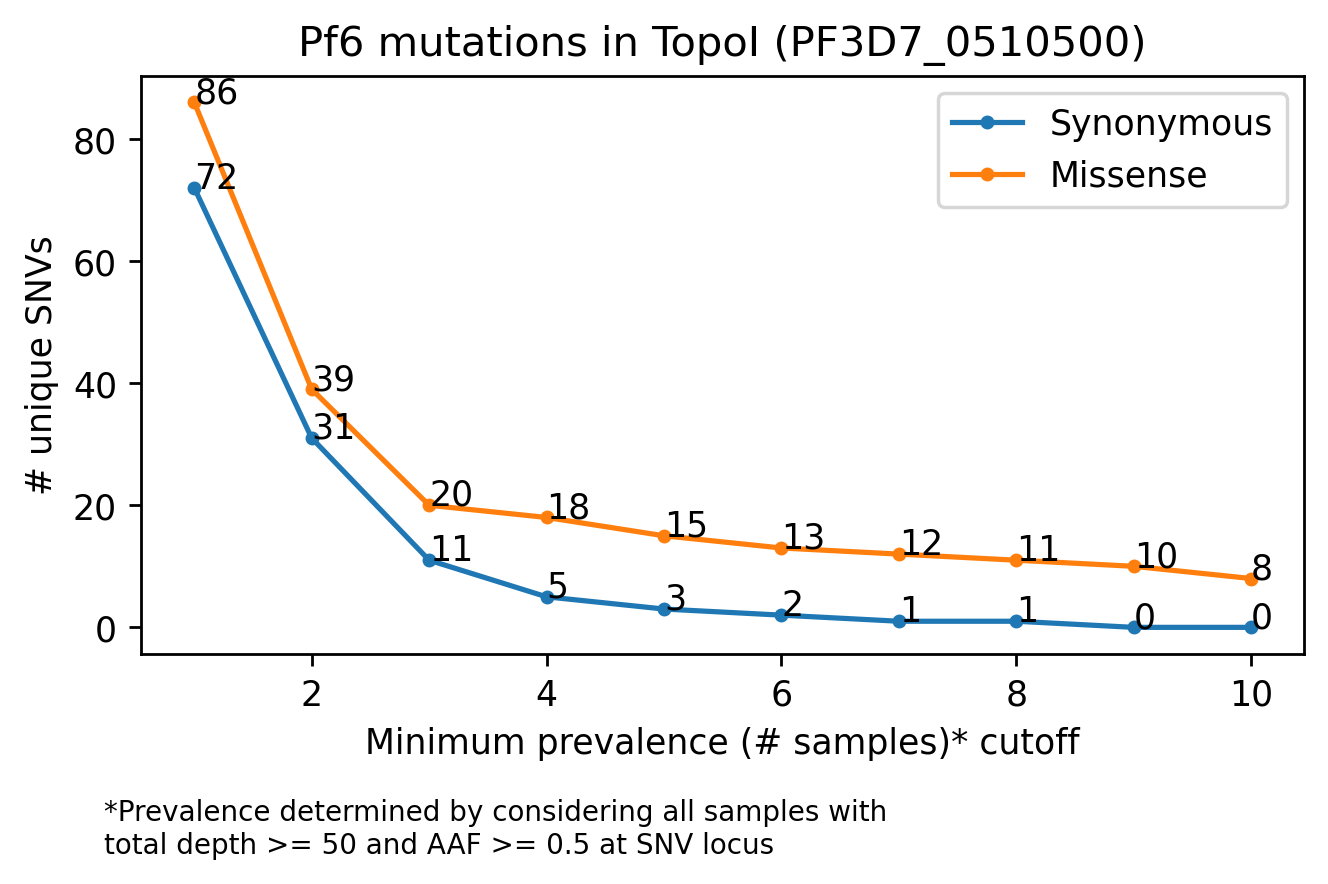

In [238]:
fig, ax = plt.subplots(figsize=(6, 3))
ordered_cutoffs = np.arange(1, 11)
syn_counts = [len(cutoff_syn_mutations[cutoff]) for cutoff in ordered_cutoffs]
mis_counts = [len(cutoff_mis_mutations[cutoff]) for cutoff in ordered_cutoffs]
ax.set_title("Pf6 mutations in TopoI (%s)" % gene)
ax.plot(ordered_cutoffs, syn_counts, '.-', label="Synonymous")
ax.plot(ordered_cutoffs, mis_counts, '.-', label="Missense")
for x, y in zip(ordered_cutoffs, syn_counts):
    ax.annotate(y, (x, y))
for x, y in zip(ordered_cutoffs, mis_counts):
    ax.annotate(y, (x, y))
ax.set_ylabel("# unique SNVs")
ax.set_xlabel("Minimum prevalence (# samples)* cutoff")
plt.figtext(0.1, -0.15, "*Prevalence determined by considering all samples with\ntotal depth >= 50 and AAF >= 0.5 at SNV locus",
           wrap=True, fontsize=8)
ax.legend()

In [255]:
for mutation in sorted(mutation_samples_dict, key=lambda m: int(m[5:-3])):
    samples = mutation_samples_dict[mutation]
    if len(samples) >= 10:
        country_samples_dict = defaultdict(list)
        for sample in samples:
            country_samples_dict[sample_country_dict[sample]].append(sample)
        items = [len(mutation_samples_dict[mutation]), mutation[2:], ' | '.join(['%s %i' % (country, len(country_samples_dict[country])) \
                                 for country in sorted(country_samples_dict)])]
        print('\t'.join([str(item) for item in items]))

16	Glu15Gly	Cambodia 3 | Laos 8 | Myanmar 2 | Thailand 1 | Viet Nam 2
21	Lys119Arg	Cambodia 7 | Laos 4 | Myanmar 4 | Thailand 4 | Viet Nam 2
16	Asp475Asn	Congo DR 5 | Ghana 2 | Madagascar 2 | Malawi 4 | Mali 2 | Tanzania 1
94	Ser598Pro	Benin 7 | Cameroon 11 | Congo DR 5 | Gambia 9 | Ghana 32 | Guinea 2 | Ivory Coast 3 | Kenya 4 | Malawi 1 | Mali 10 | Senegal 3 | Tanzania 6 | Uganda 1
14	Thr650Ala	Cameroon 1 | Kenya 1 | Malawi 6 | Mali 1 | Tanzania 5
243	Asp656Gly	Benin 10 | Burkina Faso 3 | Cameroon 24 | Congo DR 10 | Gambia 36 | Ghana 73 | Guinea 11 | Ivory Coast 5 | Kenya 4 | Malawi 9 | Mali 37 | Mauritania 5 | Nigeria 1 | Senegal 6 | Tanzania 7 | Uganda 2
17	Asp658Asn	Benin 1 | Burkina Faso 1 | Congo DR 4 | Gambia 1 | Ghana 3 | Guinea 2 | Mali 4 | Nigeria 1
13	Asn661Ser	Benin 3 | Congo DR 1 | Ghana 5 | Mali 2 | Mauritania 2


# MDR1 investigations

In [20]:
aa_changes_of_interest = ['Glu130Lys', 'Ala750Thr', 'Ser784Leu']

In [19]:
for pos, alt_allele in gene_snv_aa_change_dict[gene]:
    if pos == 960137:
        print(alt_allele)
print(gene_snv_aa_change_dict[gene][(960137, 'A')]) # Alt allele 1
print(gene_snv_aa_change_dict[gene][(960137, 'T')]) # Alt allele 2

A
T
p.Ala750Thr/c.2248G>A
p.Ala750Ser/c.2248G>T


In [20]:
print(sorted(set(sample_country_dict.values())))

['Bangladesh', 'Benin', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Colombia', 'Congo DR', 'Ethiopia', 'Gambia', 'Ghana', 'Guinea', 'Indonesia', 'Ivory Coast', 'Kenya', 'Lab', 'Laos', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Myanmar', 'Nigeria', 'Papua New Guinea', 'Peru', 'Senegal', 'Tanzania', 'Thailand', 'Uganda', 'Viet Nam']


In [41]:
def aaf_to_bin(AAF):
    if AAF <= 0:
        return 0
    elif AAF < 0.8:
        return 1
    else:
        return 2

gene = 'PF3D7_0523000'
regions = ['South America', 'Africa', 'Southeast Asia', 'Oceania']
countries = ['Bangladesh', 'Benin', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Colombia', 'Congo DR', 'Ethiopia', 'Gambia', 
             'Ghana', 'Guinea', 'Indonesia', 'Ivory Coast', 'Kenya', 'Laos', 'Madagascar', 'Malawi', 'Mali', 
             'Mauritania', 'Mozambique', 'Myanmar', 'Nigeria', 'Papua New Guinea', 'Peru', 'Senegal', 'Tanzania', 'Thailand', 
             'Uganda', 'Viet Nam']

aa_changes_of_interest = set(gene_snv_aa_change_dict[gene].values())

mutation_region_sample_aaf_bin_dict = {aa_change: {region: defaultdict(int) for region in regions} for aa_change in aa_changes_of_interest}
mutation_region_sample_GT_dict = {aa_change: {region: defaultdict(int) for region in regions} for aa_change in aa_changes_of_interest}
mutation_country_sample_GT_dict = {aa_change: {country: defaultdict(int) for country in countries} for aa_change in aa_changes_of_interest}
mutation_samples_dict = defaultdict(set)

for pos, alt in gene_snv_aa_change_dict[gene]:
    aa_change = gene_snv_aa_change_dict[gene][(pos, alt)]
    
    desired_snv_found = True # False
    aa_change_part = aa_change
    '''
    for aa_change_part in aa_changes_of_interest:
        if aa_change_part in aa_change:
            desired_snv_found = True
            break
    '''
    if desired_snv_found:
        for sample in gene_snv_sample_data_dict[gene][(pos, alt)]:
            GT, AD = gene_snv_sample_data_dict[gene][(pos, alt)][sample]
            country = sample_country_dict[sample.strip()]                
            if country == 'Lab':
                continue
            region = country_region_dict[country]
            depths = [int(d) for d in AD.split(',')]
            total_depth = sum(depths)
            if total_depth > 0:
                AAF = sum(depths[1:])/total_depth
                aaf_bin = aaf_to_bin(AAF)
                mutation_region_sample_aaf_bin_dict[aa_change_part][region][aaf_bin] += 1
            if GT != './.':
                mutation_region_sample_GT_dict[aa_change_part][region][GT] += 1
                mutation_country_sample_GT_dict[aa_change_part][country][GT] += 1

        maf = gene_snv_maf_dict[gene][(pos, alt)] if (pos, alt) in gene_snv_maf_dict[gene] else 0            
        samples_strict = gene_snv_samples_dict[gene][(pos, alt)]
        mutation_samples_dict[aa_change_part] = samples_strict
        samples = gene_snv_samples_relaxed_dict[gene][(pos, alt)]
        pf6_countries = set()
        for sample in samples:
            country = sample_country_dict[sample.strip()]
            pf6_countries.add(country)
        #print(pos, alt, gene, aa_change, maf, len(samples_strict), len(samples), ','.join(pf6_countries))

In [64]:
country_year_samples_dict = {}
for country in country_samples_dict:
    year_samples_dict = defaultdict(list)
    for sample in country_samples_dict[country]:
        year_samples_dict[sample_year_dict[sample]].append(sample)
    country_year_samples_dict[country] = year_samples_dict

aa3_to_aa1_dict = {"Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C", "Glu": "E", "Gln": "Q", "Gly": "G", 
                   "His": "H", "Ile": "I", "Leu": "L", "Lys": "K", "Met": "M", "Phe": "F", "Pro": "P", "Ser": "S", 
                   "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V", "Ter": "Ter"}

def aa_change_to_abbr(aa_change):
    if 'p.' not in aa_change:
        return aa_change
    aa_change_only = aa_change.split('/')[0].split('p.')[1]
    aa1_1 = aa3_to_aa1_dict[aa_change_only[:3]]
    if aa_change_only[-3:] in aa3_to_aa1_dict:
        aa1_2 = aa3_to_aa1_dict[aa_change_only[-3:]]
        return aa1_1 + aa_change_only[3:-3] + aa1_2
    else:
        return aa1_1 + aa_change_only[3:]

In [71]:
sample_mutations_dict = defaultdict(set)
for mutation in mutation_samples_dict:
    for sample in mutation_samples_dict[mutation]:
        if sample_country_dict[sample.strip()] != 'Lab':
            sample_mutations_dict[sample].add(mutation)

countries_of_interest = set()
for sample in sorted(sample_mutations_dict, key=lambda x: sample_year_dict[x.strip()]):
    mutations_str = ', '.join(sample_mutations_dict[sample])
    country = sample_country_dict[sample]
    if '130' in mutations_str:
        countries_of_interest.add(country)
    site = sample_site_dict[sample]
    year = sample_year_dict[sample]
    print('\t'.join([sample, country, str(year), site + '  ', mutations_str]))

PD1276-C	Thailand	2001	Mae Sot  	p.Asn86Tyr
PD1279-C	Thailand	2001	Mae Sot  	p.Glu130Lys, p.Ala750Thr
PD1261-C	Thailand	2001	Mae Sot  	p.Glu130Lys, p.Ala750Thr
PD1252-C	Thailand	2001	Mae Sot  	p.Glu130Lys
PD1270-C	Thailand	2001	Mae Sot  	p.Glu130Lys, p.Ala750Thr
PD1434-C	Thailand	2001	Mae Sot  	p.Tyr184Phe
PD1266-C	Thailand	2001	Mae Sot  	p.Tyr184Phe, p.Ser784Leu
PD1285-C	Thailand	2001	Mae Sot  	p.Tyr184Phe
PD1278-C	Thailand	2001	Mae Sot  	p.Tyr184Phe
PD1284-C	Thailand	2001	Mae Sot  	p.Tyr184Phe, p.Ser784Leu
PD1277-C	Thailand	2001	Mae Sot  	p.Tyr184Phe, p.Ser784Leu
PD0008-02	Thailand	2001	Mae Sot  	p.Tyr184Phe
PD1282-C	Thailand	2001	Mae Sot  	p.Ala750Thr
PD1253-C	Thailand	2001	Mae Sot  	p.Ala750Thr
PD1255-C	Thailand	2001	Mae Sot  	p.Ser784Leu
PD1256-C	Thailand	2001	Mae Sot  	p.Phe1226Tyr
PD1269-C	Thailand	2001	Mae Sot  	p.Phe1226Tyr
PD1257-C	Thailand	2001	Mae Sot  	p.Phe1226Tyr
PD1264-C	Thailand	2001	Mae Sot  	p.Phe1226Tyr
PD1254-C	Thailand	2001	Mae Sot  	p.Phe1226Tyr
PD1283-C	Thailand

KeyError: 'QV0112-C\n'

In [65]:
country_year_mutation_freq_dict = defaultdict(dict)
for country in country_year_samples_dict:
    if country == 'Lab':
        continue
    for year in sorted(country_year_samples_dict[country]):
        mutation_count_dict = defaultdict(int)
        n = len(country_year_samples_dict[country][year])
        for sample in country_year_samples_dict[country][year]:
            for mutation in sample_mutations_dict[sample]:
                mutation_count_dict[aa_change_to_abbr(mutation)] += 1
        country_year_mutation_freq_dict[country][year] = {m: count/n for m, count in mutation_count_dict.items()}
    

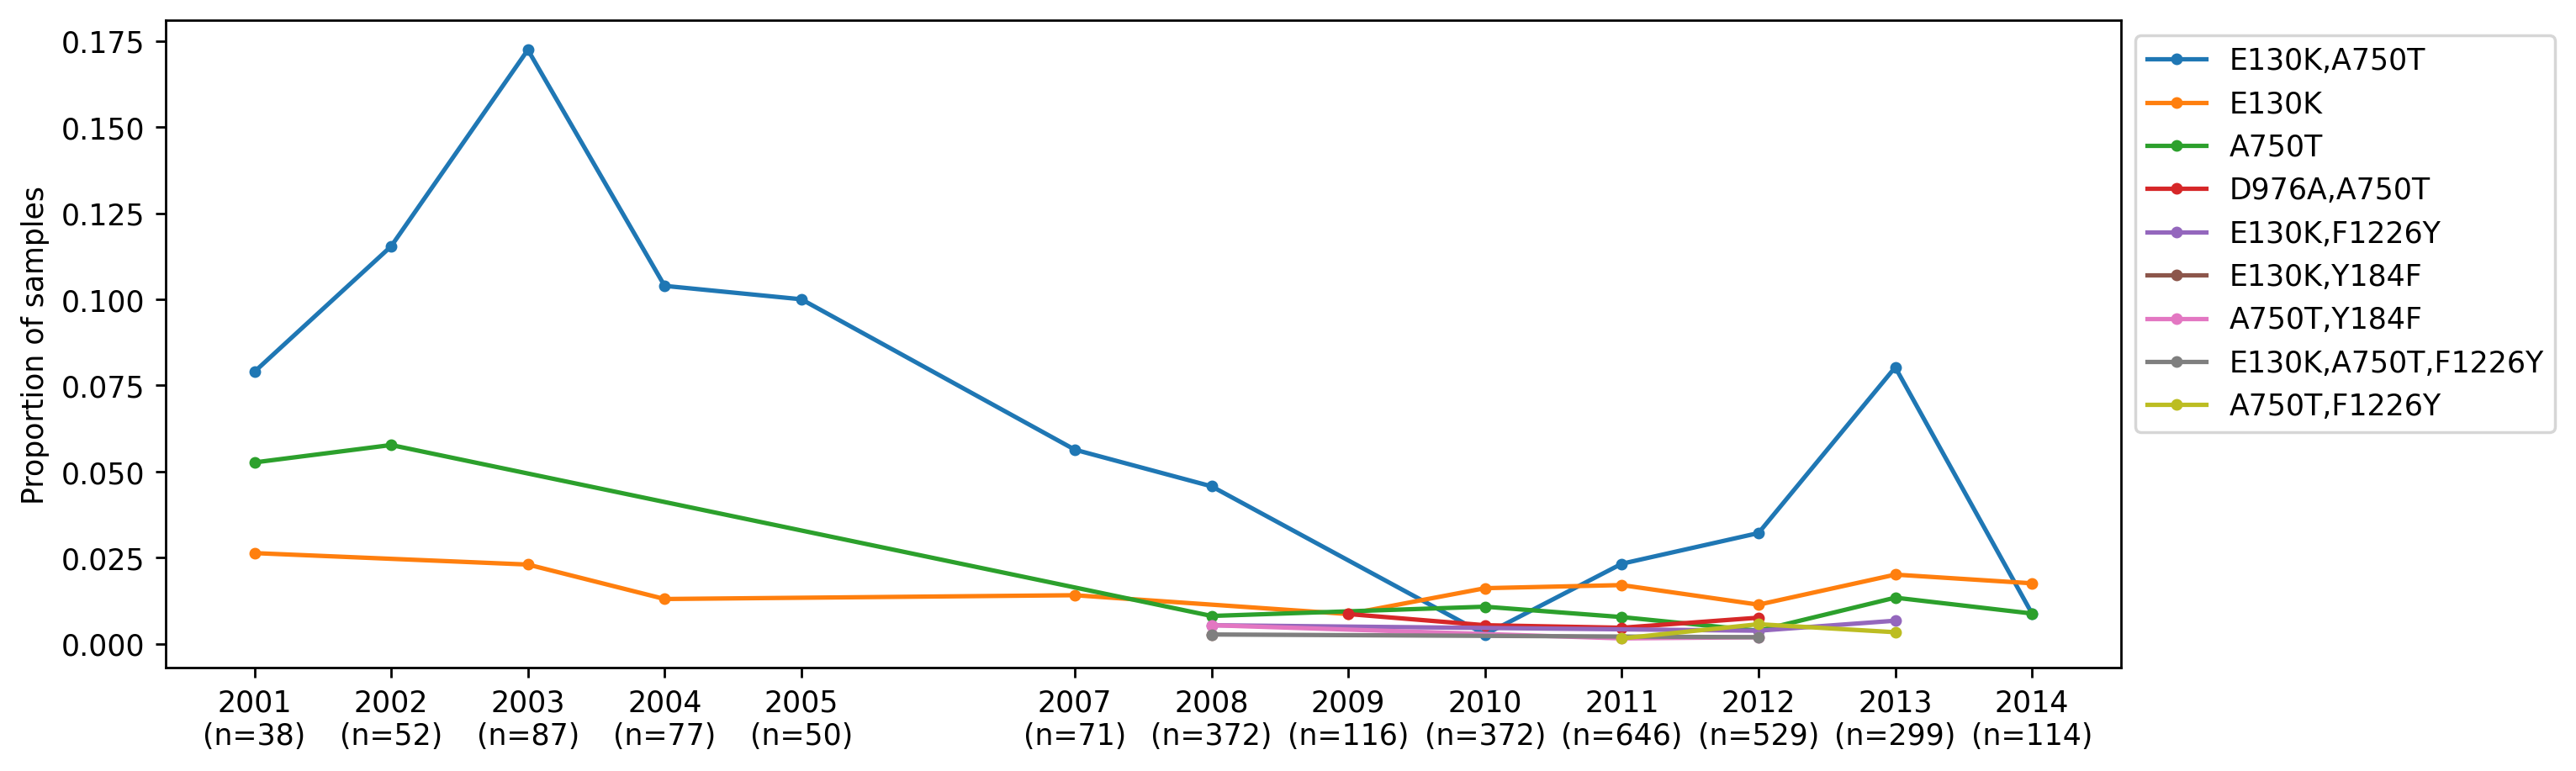

In [162]:
GMS_year_total_samples_dict = defaultdict(int)
hap_GMS_year_samples_of_interest_dict = {}

for country in countries_of_interest:
    for year in country_year_samples_dict[country]:
        for sample in country_year_samples_dict[country][year]:
            all_mutations = sample_mutations_dict[sample]
            haplotype_str = ','.join([aa_change_to_abbr(mutation) for mutation in all_mutations])
            if haplotype_str not in hap_GMS_year_samples_of_interest_dict:
                hap_GMS_year_samples_of_interest_dict[haplotype_str] = defaultdict(int)
            hap_GMS_year_samples_of_interest_dict[haplotype_str][year] += 1
            GMS_year_total_samples_dict[year] += 1

hap_GMS_year_freq_dict = defaultdict(dict)
for hap in hap_GMS_year_samples_of_interest_dict:
    for year in hap_GMS_year_samples_of_interest_dict[hap]:
        hap_GMS_year_freq_dict[hap][year] = hap_GMS_year_samples_of_interest_dict[hap][year]/float(GMS_year_total_samples_dict[year])

fig, ax = plt.subplots(figsize=(12, 4))
all_years = set()
for hap in hap_GMS_year_freq_dict:
    if '750' in hap or '130' in hap:
        years = []; freqs = []; labels = []
        for year, freq in sorted(hap_GMS_year_freq_dict[hap].items(), key=lambda x: x[0]):
            tot = GMS_year_total_samples_dict[year]
            num = hap_GMS_year_samples_of_interest_dict[hap][year]
            years.append(year); freqs.append(freq); all_years.add(year)
        ax.plot(years, freqs, '.-', label=hap)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Proportion of samples")
ax.set_xticks(sorted(all_years))
ax.set_xticklabels(["%i\n(n=%i)" % (year, GMS_year_total_samples_dict[year]) for year in sorted(all_years)])
plt.show()

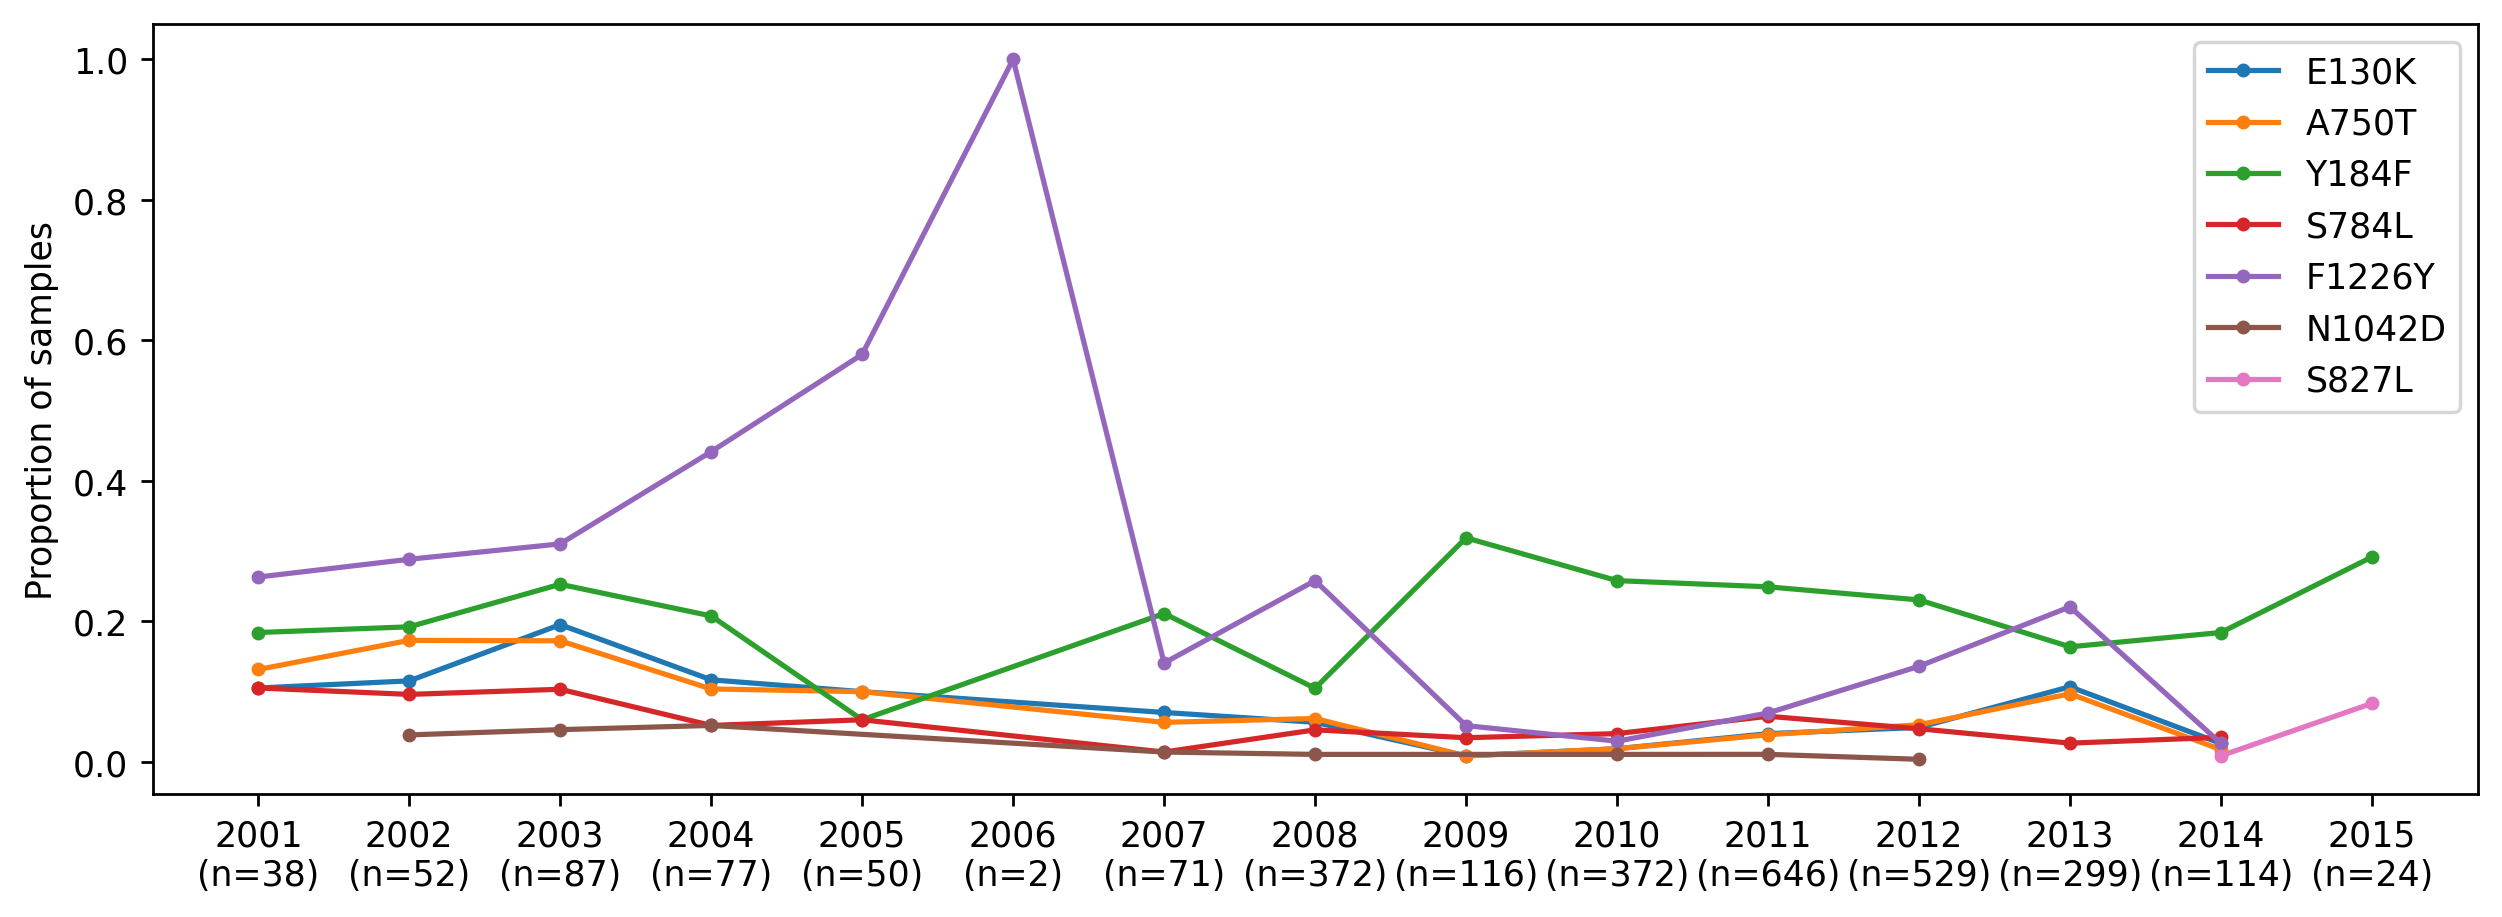

In [166]:
GMS_year_total_samples_dict = defaultdict(int)
mut_GMS_year_samples_of_interest_dict = {}

for country in countries_of_interest:
    for year in country_year_samples_dict[country]:
        for sample in country_year_samples_dict[country][year]:
            for mutation in sample_mutations_dict[sample]:
                if mutation not in mut_GMS_year_samples_of_interest_dict:
                    mut_GMS_year_samples_of_interest_dict[mutation] = defaultdict(int)
                mut_GMS_year_samples_of_interest_dict[mutation][year] += 1
            GMS_year_total_samples_dict[year] += 1

mut_GMS_year_freq_dict = defaultdict(dict)
for mut in mut_GMS_year_samples_of_interest_dict:
    for year in mut_GMS_year_samples_of_interest_dict[mut]:
        mut_GMS_year_freq_dict[mut][year] = mut_GMS_year_samples_of_interest_dict[mut][year]/float(GMS_year_total_samples_dict[year])

fig, ax = plt.subplots(figsize=(12, 4))
all_years = set()
for mutation in mut_GMS_year_freq_dict:
    if max(mut_GMS_year_freq_dict[mutation].values()) > 0.05:#'750' in mutation or '130' in mutation or '784' in mutation:
        # print(mutation)
        years = []; freqs = []
        for year, freq in sorted(mut_GMS_year_freq_dict[mutation].items(), key=lambda x: x[0]):
            tot = GMS_year_total_samples_dict[year]
            num = mut_GMS_year_samples_of_interest_dict[mutation][year]
            # print(year, num, tot, freq, sep='\t')
            years.append(year); freqs.append(freq); all_years.add(year)

        ax.plot(years, freqs, '.-', label=aa_change_to_abbr(mutation))
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Proportion of samples")
ax.set_xticks(sorted(all_years))
ax.set_xticklabels(["%i\n(n=%i)" % (year, GMS_year_total_samples_dict[year]) for year in sorted(all_years)])
plt.show()

Myanmar ['E130K', 'S784L', 'A750T', 'N86Y', 'G968A', 'N1042D', 'T70I', 'Y184F', 'F1226Y']
Viet Nam ['E130K', 'D976A', 'N752H', 'G416S', 'Y184F', 'S784L', 'A750T', 'N86Y', 'N1042D', 'V1109I', 'F1226Y']
Thailand ['E130K', 'L1039F', 'S1034I', 'S784L', 'D1246Y', 'A750T', 'N86Y', 'G968A', 'N1042D', 'R1328K', 'Y184F', 'F1226Y', 'S1034C']
Cambodia ['E130K', 'D976A', 'E235K', 'N752H', 'P72S', 'V326G', 'G293D', 'F1068L', 'Y184F', 'L327H', 'R1319G', 'S827L', 'S1087L', 'R945P', 'S784L', 'V326A', 'G1314D', 'L936F', 'A750T', 'N86Y', 'D144Y', 'N1042D', 'V1109I', 'R1328K', 'M993I', 'F1226Y']
Laos ['E130K', 'A576V', 'L13I', 'D976A', 'N752H', 'A750T', 'V1109I', 'R1328K', 'Y184F', 'F1226Y', 'N652D']


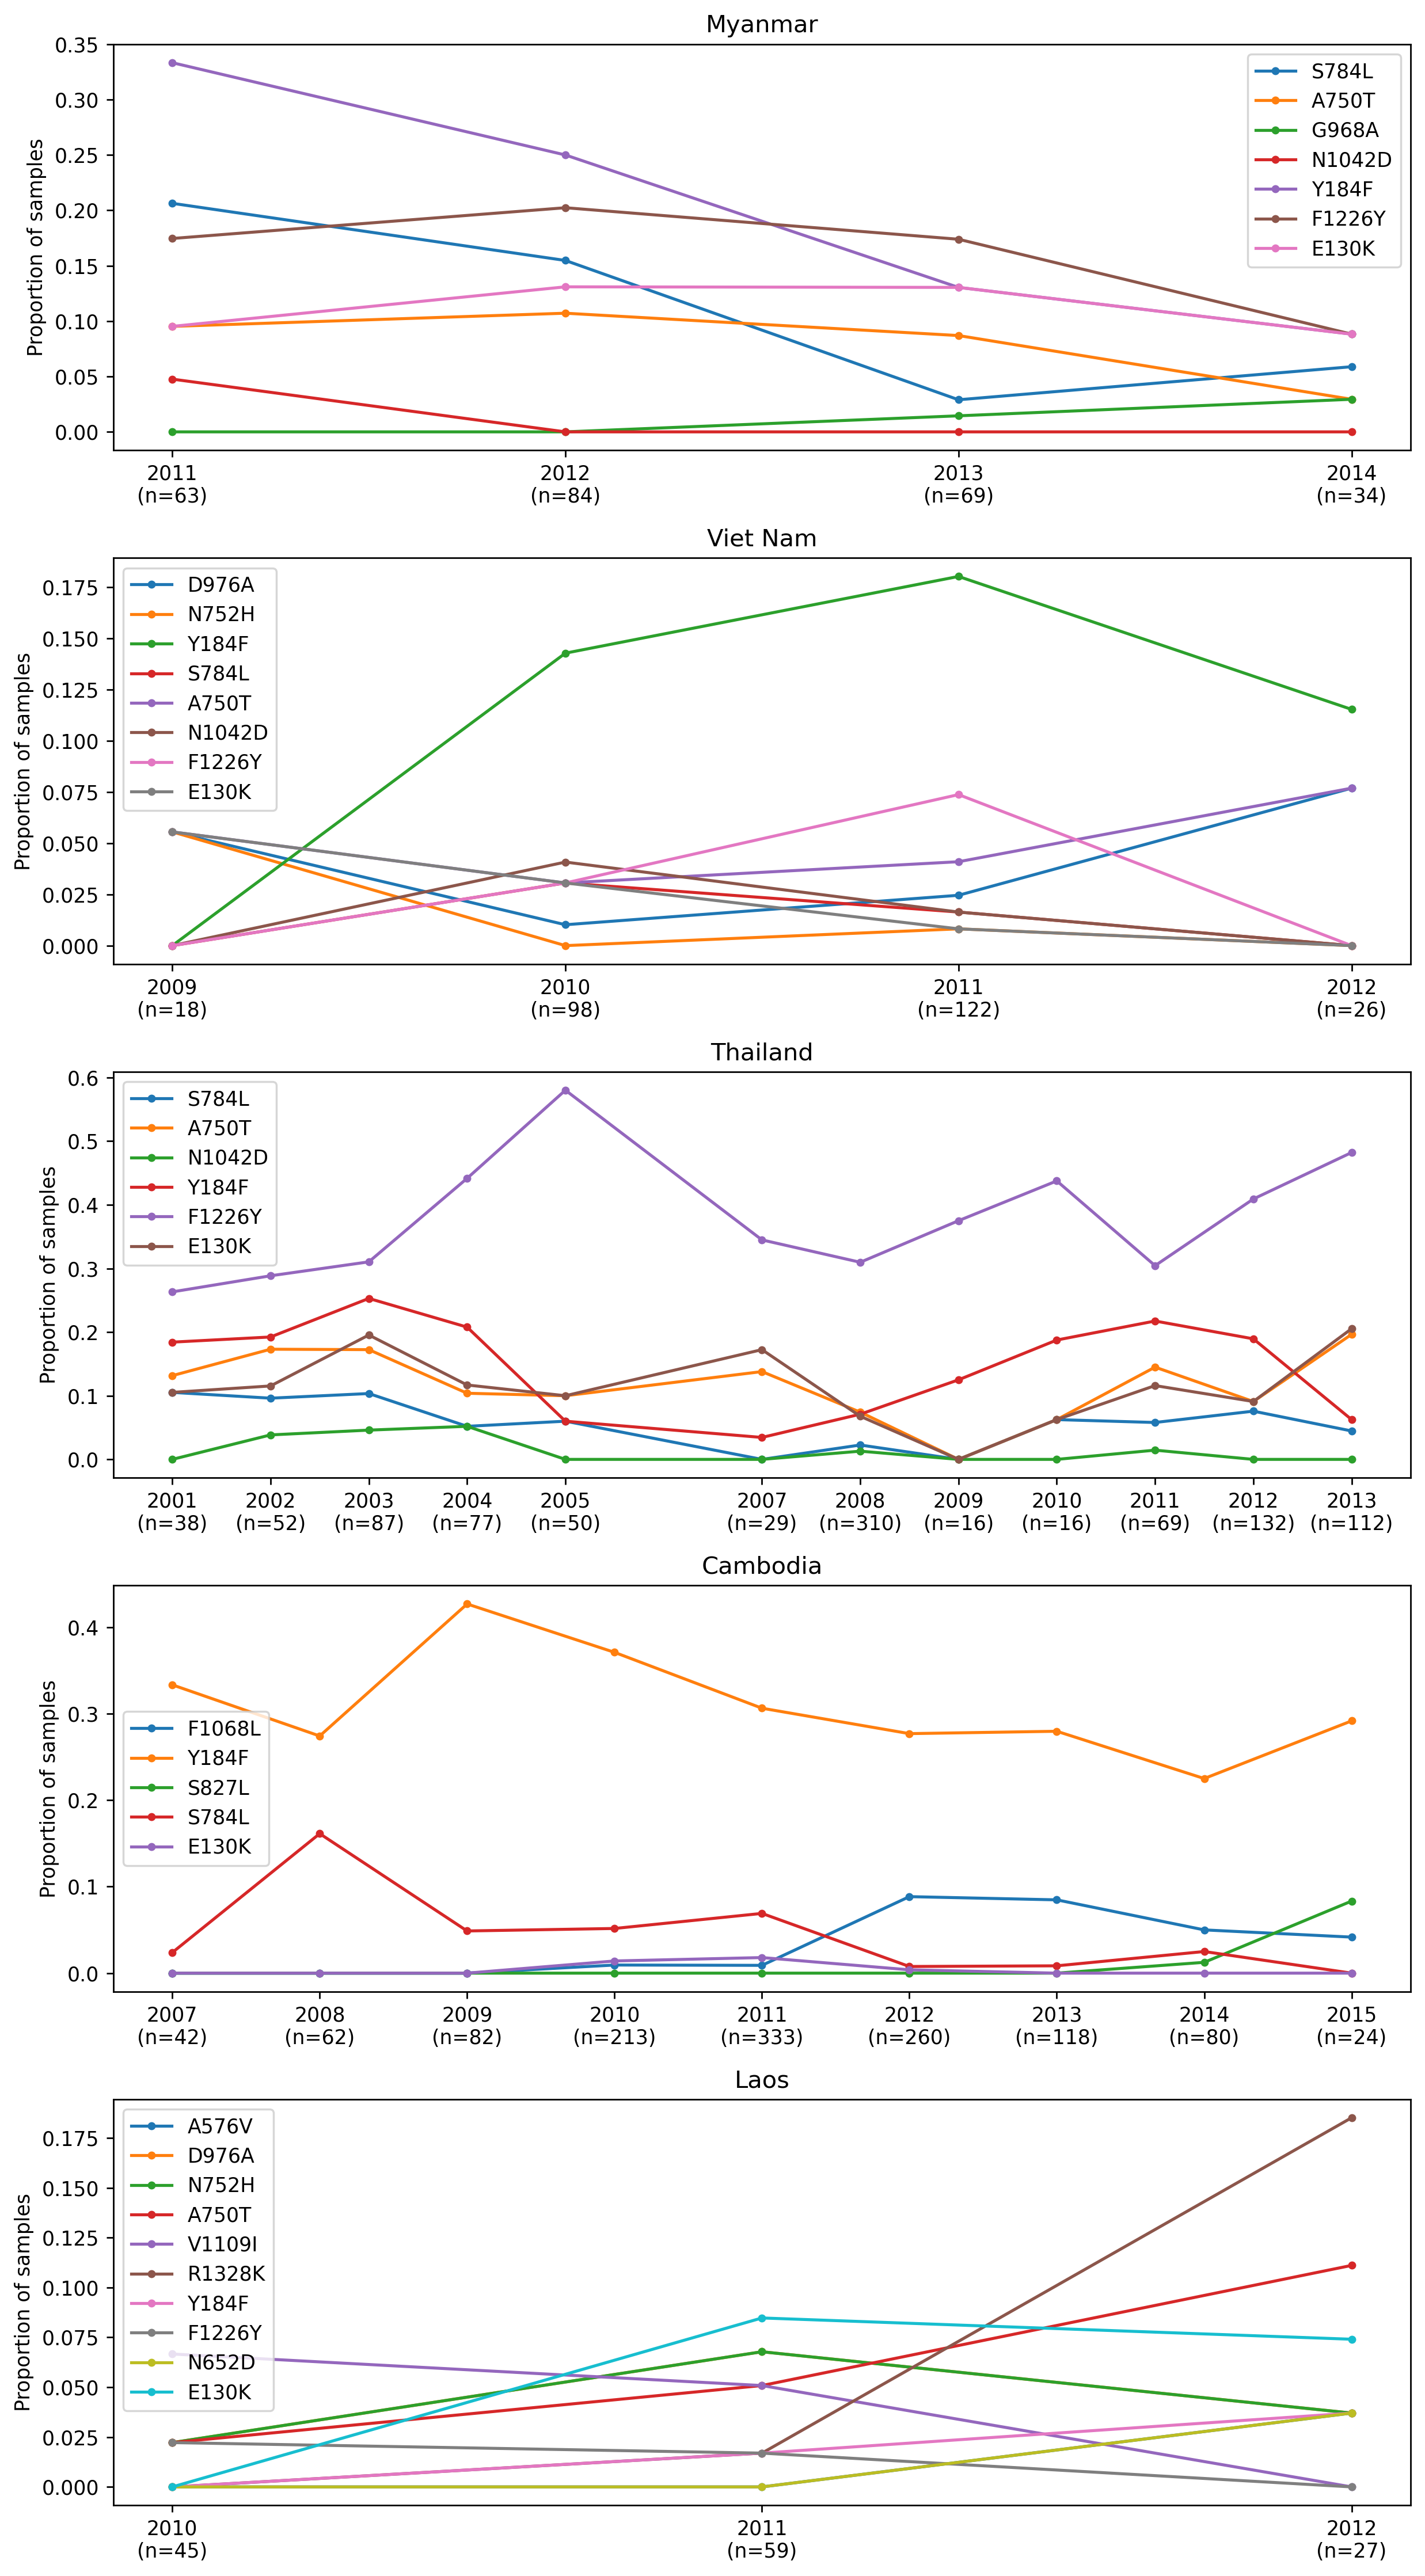

In [164]:
fig, ax = plt.subplots(5,1, figsize=(10,18))

for i, country in enumerate(countries_of_interest):
    good_years = []
    for y in country_year_samples_dict[country]:
        if len(country_year_samples_dict[country][y]) > 3:
            good_years.append(y)
    ordered_years = sorted(good_years)
    year_labels = ["%s\n(n=%i)" % (y, len(country_year_samples_dict[country][y])) for y in ordered_years]
    all_mutations = list(set().union(*[set(country_year_mutation_freq_dict[country][year].keys()) for year in ordered_years]))
    print(country, all_mutations)
    
    all_mutations.remove('E130K'); all_mutations.append('E130K')
    for mutation in all_mutations:
        freqs = [country_year_mutation_freq_dict[country][year][mutation] \
                 if mutation in country_year_mutation_freq_dict[country][year] else 0 \
                 for year in ordered_years]
        if np.mean(freqs) >= 0.01 or mutation == 'E130K':
            ax[i].plot(ordered_years, freqs, '.-', label=mutation)
    
    ax[i].set_xticks(ordered_years)
    ax[i].set_xticklabels(year_labels)
    # ax[i].set_ylim((0, 1))
    ax[i].legend()
    ax[i].set_title(country)
    ax[i].set_ylabel("Proportion of samples")

plt.tight_layout()

In [80]:
for mutation in mutation_region_sample_GT_dict:
    print('MDR1', mutation)
    for region in ['South America', 'Africa', 'Southeast Asia', 'Oceania']:
        print('\t%s (n=%i)' % (region, sum(mutation_region_sample_GT_dict[mutation][region].values())))
        for GT in mutation_region_sample_GT_dict[mutation][region]:
            print('\t   %s: %i samples' % (GT, mutation_region_sample_GT_dict[mutation][region][GT]))
    print('')

MDR1 Glu130Lys
	South America (n=39)
	   0/0: 39 samples
	Africa (n=3762)
	   0/0: 3762 samples
	Southeast Asia (n=2957)
	   0/0: 2699 samples
	   0/1: 92 samples
	   1/1: 166 samples
	Oceania (n=135)
	   0/0: 135 samples

MDR1 Ala750Thr
	South America (n=39)
	   0/0: 39 samples
	Africa (n=3766)
	   0/0: 3765 samples
	   0/2: 1 samples
	Southeast Asia (n=2963)
	   0/0: 2681 samples
	   0/1: 101 samples
	   1/1: 181 samples
	Oceania (n=135)
	   0/0: 135 samples

MDR1 Ser784Leu
	South America (n=39)
	   0/0: 39 samples
	Africa (n=3776)
	   0/0: 3776 samples
	Southeast Asia (n=2959)
	   0/0: 2707 samples
	   0/1: 85 samples
	   1/1: 167 samples
	Oceania (n=133)
	   0/0: 133 samples



# MDR1 SNV table

In [81]:
import gzip
vcf_file = gzip.open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf_60_public_Pf3D7_05_v3.final.vcf.gz', 'rt')
samples = []
for line in vcf_file:
    if line[:6] == '#CHROM':
        samples = line.split('\t')[9:]
    if line[:2] != '##':
        break
print("Number of samples: %i" % len(samples))

Number of samples: 7113


In [86]:
# Make table detailing SNVs of interest
gene = 'PF3D7_0523000'
aa_changes_of_interest = ['Glu130Lys', 'Ala750Thr', 'Ser784Leu']

o = open('MDR1_Pf6_SNV_details.tsv', 'w')
header_items = ['Chromosome', 'Position', 'Annotation', 'Group Type', 'Group', 'Total # samples', '0/0 # samples', '0/1 # samples', '1/1 # samples', '0/2 # samples', 'Global allele frequency']
o.write('\t'.join(header_items) + '\n')

f = open('/storage/NFS/ROTATION_PROJECT/daisy/PopGen/pf6/Pf6-%s.ann.txt' % gene, 'r')
for line in f:
    items = line.strip().split('\t')
    CHROM, POS, ID, REF, ALT, QUAL, FILTER, INFO, FORMAT = items[:9]
    alleles = [REF] + ALT.split(',')
    POS = int(POS)
    
    pre_eff = INFO.split(';EFF=')[0]
    eff = INFO.split(';EFF=')[1].split(';')[0]
    alt_allele_anno_dict = {}
    
    desired_snv_found = False
    for anno in eff.split(','):
        alt_allele = anno.split('|')[-1].split(')')[0]
        effect, rest = anno.split('('); impact, codon_change, aa_change = rest.split('|')[1:4]  
        alt_allele_anno_dict[alt_allele] = (effect, impact, codon_change, aa_change)
        for aa_change_part in aa_changes_of_interest:
            if aa_change_part in aa_change:
                desired_snv_found = True
    
    if not desired_snv_found:
        continue
    
    country_GT_count_dict = {c: defaultdict(int) for c in countries}; country_global_total_depth = defaultdict(int); country_global_alt_allele_depth = {c: defaultdict(int) for c in countries}
    region_GT_count_dict = {r: defaultdict(int) for r in regions}; region_global_total_depth = defaultdict(int); region_global_alt_allele_depth = {r: defaultdict(int) for r in regions}
    
    for tup, sample in zip(items[9:], samples): # FORMAT is GT:AD:DP:PGT:PID
        country = sample_country_dict[sample.strip()]
        region = country_region_dict[country]
        GT, AD, DP = tup.split(':')[:3]
        if country == 'Lab' or DP == '.':
            continue
        if GT != './.':
            depths = [int(depth) for depth in AD.split(',')]
            total_depth = sum(depths)
            
            country_GT_count_dict[country][GT] += 1
            country_global_total_depth[country] += total_depth
            for alt_allele_i in range(1, len(depths)):
                alt_depth = depths[alt_allele_i]
                country_global_alt_allele_depth[country][alleles[alt_allele_i]] += alt_depth
            
            region_GT_count_dict[region][GT] += 1
            region_global_total_depth[region] += total_depth
            for alt_allele_i in range(1, len(depths)):
                alt_depth = depths[alt_allele_i]
                region_global_alt_allele_depth[region][alleles[alt_allele_i]] += alt_depth
    
    
    alt_allele_aa_change_abbr_dict = {}
    for alt_allele in alleles[1:]:
        aa_change_abbr = alt_allele_anno_dict[alt_allele][3].lstrip('p.').split('/')[0]
        alt_allele_aa_change_abbr_dict[alt_allele] = aa_change_abbr
    
    alt_allele = alleles[1]
    for region in regions:
        GAF = region_global_alt_allele_depth[region][alt_allele]/region_global_total_depth[region]
        items = [CHROM, POS, alt_allele_aa_change_abbr_dict[alt_allele], 'Region', region, 
                 sum(region_GT_count_dict[region].values()), region_GT_count_dict[region]['0/0'], 
                 region_GT_count_dict[region]['0/1'], region_GT_count_dict[region]['1/1'], 
                 region_GT_count_dict[region]['0/2'], GAF]   
        o.write('\t'.join([str(item) for item in items]) + '\n')
    
    for country in countries:
        GAF = country_global_alt_allele_depth[country][alt_allele]/country_global_total_depth[country]
        items = [CHROM, POS, alt_allele_aa_change_abbr_dict[alt_allele], 'Country', country, 
                 sum(country_GT_count_dict[country].values()), country_GT_count_dict[country]['0/0'], 
                 country_GT_count_dict[country]['0/1'], country_GT_count_dict[country]['1/1'], 
                 country_GT_count_dict[country]['0/2'], GAF]
        o.write('\t'.join([str(item) for item in items]) + '\n')

o.close()

In [57]:
for gene, chrom, pos, ref, alt in mutations_of_interest:
    try:
        samples = gene_snv_samples_dict[gene][(int(pos), alt)]
        pf6_countries = set()
        for sample in samples:
            pf6_countries.add(sample_country_dict[sample.strip()])
        print(','.join(sorted(pf6_countries)))
        #print(gene_snv_aa_change_dict[gene][(int(pos), alt)])
        #print('')
    except:
        print(gene, chrom, pos, ref, alt)
        #print('')

Benin,Burkina Faso,Cameroon,Congo DR,Gambia,Ghana,Guinea,Ivory Coast,Kenya,Malawi,Mali,Mauritania,Nigeria,Senegal,Tanzania
Bangladesh,Benin,Burkina Faso,Cambodia,Cameroon,Colombia,Congo DR,Ethiopia,Gambia,Ghana,Guinea,Indonesia,Ivory Coast,Kenya,Lab,Laos,Madagascar,Malawi,Mali,Mauritania,Myanmar,Nigeria,Papua New Guinea,Peru,Senegal,Tanzania,Thailand,Uganda,Viet Nam
Burkina Faso,Ghana,Mali
Benin,Cameroon,Ghana,Ivory Coast,Mali

Congo DR,Kenya,Tanzania


In [47]:
country_subset_count_dict = defaultdict(int)
for sample in pf6_samples_to_characterize:
    country = sample_country_dict[sample]
    country_subset_count_dict[country] += 1

for country in sorted(country_samples_dict):
    print("%i/%i\t%s" % (country_subset_count_dict[country], len(country_samples_dict[country]), country))

NameError: name 'pf6_samples_to_characterize' is not defined

In [49]:
pf6_samples_to_characterize = set()
gene = 'PF3D7_1113300'
for snv in gene_snv_aa_change_dict[gene]:
    if '94' in gene_snv_aa_change_dict[gene][snv]: # Gly293, Asn1042
        print('\n--------\n')
        print(gene, snv, gene_snv_aa_change_dict[gene][snv])
        print(evolved_gene_ns_snv_count_dict[gene][snv])
        for sample in gene_snv_sample_data_dict[gene][snv]:
            GT, AD = gene_snv_sample_data_dict[gene][snv][sample]            
            if GT != '0/0' and GT != './.':
                rd, ad = AD.split(','); td = int(rd) + int(ad)
                print(sample, GT, AD, sample_country_dict[sample], sample_year_dict[sample], td)
                pf6_samples_to_characterize.add(sample)

In [17]:
for gene in featured_genes:
    print("====================\n%s\n====================" % big_gene_desc_dict[gene])
    for pos, alt in evolved_gene_ns_snv_count_dict[gene]:
        if (pos, alt) in gene_snv_sample_data_dict[gene]:
            for sample in gene_snv_sample_data_dict[gene][(pos, alt)]:
                GT, AD = gene_snv_sample_data_dict[gene][(pos, alt)][sample]
                if GT != '0/0' and GT != './.':
                    print(sample, GT, AD, gene_snv_aa_change_dict[gene][(pos, alt)])

cyclic amine resistance locus protein (CARL)
multidrug resistance protein (MDR1)
PH0125-CW 1/1 2,24 p.Phe806Leu/c.2418T>G
PH0430-C 1/1 0,5 p.Gly293Asp/c.878G>A
PH0888-C 1/1 0,32 p.Gly293Asp/c.878G>A
PH0890-C 1/1 0,82 p.Gly293Asp/c.878G>A
PH0899-C 1/1 0,64 p.Gly293Asp/c.878G>A
PH0900-C 1/1 0,68 p.Gly293Asp/c.878G>A
PH0901-C 1/1 1,32 p.Gly293Asp/c.878G>A
PH0904-C 1/1 0,21 p.Gly293Asp/c.878G>A
PH0907-C 1/1 1,58 p.Gly293Asp/c.878G>A
PH0908-C 1/1 0,94 p.Gly293Asp/c.878G>A
PH0910-C 1/1 0,17 p.Gly293Asp/c.878G>A
PH0911-Cx 1/1 0,8 p.Gly293Asp/c.878G>A
PH0914-Cx 1/1 0,6 p.Gly293Asp/c.878G>A
PH0915-C 1/1 1,119 p.Gly293Asp/c.878G>A
PH0916-C 1/1 7,98 p.Gly293Asp/c.878G>A
PH0989-C 1/1 0,76 p.Gly293Asp/c.878G>A
PH0990-C 1/1 1,85 p.Gly293Asp/c.878G>A
PH0991-C 1/1 0,19 p.Gly293Asp/c.878G>A
PH1001-C 1/1 1,138 p.Gly293Asp/c.878G>A
PH1002-C 1/1 0,45 p.Gly293Asp/c.878G>A
PD0058-C 1/1 3,125 p.Asn1042Asp/c.3124A>G
PD0060-C 1/1 2,370 p.Asn1042Asp/c.3124A>G
PD0061-C 1/1 0,144 p.Asn1042Asp/c.3124A>G
PD0100-C 1

In [28]:
gene = 'PF3D7_1211900'
ns_snvs = set(); s_snvs = set()
ns_aa_tups = set()
for snv in gene_filtered_snv_dict[gene]:
    aa_change = gene_snv_aa_change_dict[gene][snv]
    impact = gene_snv_impact_dict[gene][snv]
    if impact == 'MISSENSE':
        ns_snvs.add(snv)
        ns_aa_tups.add(aa_change_to_tup(aa_change))
    else:
        s_snvs.add(snv)

print(len(ns_aa_tups))
print(len(s_snvs), len(ns_snvs), len(s_snvs) + len(ns_snvs))
print(len(s_snvs)/(len(ns_snvs) + len(s_snvs)))

35
21 40 61
0.3442622950819672


In [27]:
gene = 'PF3D7_0523000'
ns_snvs = set(); s_snvs = set()
ns_aa_tups = set()
for snv in gene_filtered_snv_dict[gene]:
    aa_change = gene_snv_aa_change_dict[gene][snv]
    impact = gene_snv_impact_dict[gene][snv]
    if impact == 'MISSENSE':
        ns_snvs.add(snv)
        ns_aa_tups.add(aa_change_to_tup(aa_change))
    else:
        s_snvs.add(snv)

print(len(ns_aa_tups))
print(len(s_snvs), len(ns_snvs), len(s_snvs) + len(ns_snvs))
print(len(s_snvs)/(len(ns_snvs) + len(s_snvs)))

36
28 37 65
0.4307692307692308


In [28]:
num_ns = 0
for gene, _, _ in test_gene_aa_pos_tups:
    if gene == 'MDR1':
        num_ns += 1
print(num_ns)

36


In [53]:
# Check consistency with Karla's pymol

plotted_gene_aa_pos_tups = set()
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/snv_model.txt', 'r')
header = f.readline()
for line in f:
    gene, aa_pos = line.strip().split('\t')
    aa, pos = aa_pos.split(' ')
    # print(gene, aa, pos)
    plotted_gene_aa_pos_tups.add((gene, aa, int(pos)))

In [54]:
print(test_gene_aa_pos_tups.difference(plotted_gene_aa_pos_tups))
print(plotted_gene_aa_pos_tups.difference(test_gene_aa_pos_tups))

{('ATP4', 'Gly', 223), ('MDR1', 'Gly', 293)}
set()


In [38]:
for gene in gene_plotted_pos_dict:
    if set(gene_plotted_pos_dict[gene]) != gene_plotted_in_table_pos_dict[gene]:
        print('sus')

# dN dS stuff

In [13]:
gene = 'PF3D7_1211900.1' # PfCARL

snv_samples_dict = defaultdict(set) # snv -> samples

for sample in all_good_samples:
    if gene in sample_gene_ns_s_dict[sample]:
        ns_snvs, s_snvs = sample_gene_ns_s_dict[sample][gene]
        for ns_snv in ns_snvs:
            snv_samples_dict[ns_snv].add(sample)
        for s_snv in s_snvs:
            snv_samples_dict[s_snv].add(sample)

for snv in sorted(snv_samples_dict):
    if len(snv_samples_dict[snv]) > 1:
        print(snv, len(snv_samples_dict[snv]))

529076 8
529091 46
529122 2
529134 5
529187 14
529233 2
529236 3
529241 5
529329 4
529344 7
529346 13
529364 5
529389 4
529390 7
529395 3
529396 3
529418 2266
529422 5
529429 97
529432 2
529441 2
529443 11
529453 132
529454 61
529457 21
529477 3
529487 29
529550 15
529558 7
529559 1436
529602 2
529650 4
529665 166
529704 3
529707 499
529709 66
529751 2
529835 16
529854 3
530109 2
530274 10
530382 2
530388 2
530406 2
530408 3
530430 3
530589 2
530646 2
530705 50
530735 7
530761 2
530791 3
530811 2
530874 3
530898 4
530912 5
530975 10
531005 4
531009 3
531011 28
531017 5
531023 3
531031 7
531047 2
531110 3
531156 7
531168 3
531177 19
531184 2
531192 2
531222 4
531249 2
531280 49
531286 2
531289 12
531441 4
531459 4
531582 2
531588 2
531597 2
531636 31
531681 4
531689 4
531702 6
531722 11
531775 3
531801 2
531829 24
531923 13
532010 7
532013 4
532014 6
532074 9
532075 3
532110 2
532112 10
532113 568
532131 1572
532133 410
532185 15
532208 3
532312 3
532314 2
532316 2
532351 2
532386 2
532

In [14]:
evolved_gene_dnds_dict = {} # gene -> dN/dS
evolved_gene_dn_dict = {} # gene -> dN
evolved_gene_ds_dict = {} # gene -> dS

evolved_gene_ns_count_dict = {} # gene -> number of unique NS SNVs
evolved_gene_snv_count_dict = {} # gene -> number of unique SNVs

evolved_nonsingleton_genes = set()

for gene in evolved_all_genes:
    if gene not in big_gene_expn_exps_dict: # TODO
        # print(gene)
        continue
    
    ns_independent_count = 0; ns_snvs = set()
    if gene in evolved_gene_ns_snv_count_dict:
        for snv in evolved_gene_ns_snv_count_dict[gene]:
            ns_independent_count += evolved_gene_ns_snv_count_dict[gene][snv]
            ns_snvs.add(snv)
    
    ns_count = len(ns_snvs) # Number of unique missense SNVs
    
    s_independent_count = 0; s_snvs = set()
    if gene in evolved_gene_s_snv_count_dict:
        for snv in evolved_gene_s_snv_count_dict[gene]:
            s_independent_count += evolved_gene_s_snv_count_dict[gene][snv]
            s_snvs.add(snv)
    
    s_count = len(s_snvs) # Number of unique synonymous SNVs
    
    if gene == 'PF3D7_0203000':
        print(evolved_gene_ns_snv_count_dict[gene], ns_count, s_count)
    
    # ns_count = len(evolved_gene_ns_snvs_dict[gene])
    # s_count = len(evolved_gene_s_snvs_dict[gene])
    expn, exps = big_gene_expn_exps_dict[gene]
    pseudo_dN = 1.0/(exps/2.0+expn)
    pseudo_dS = 1.0/(exps/2.0+expn)
    dNdS = (pseudo_dN + (ns_count/expn))/(pseudo_dS + (s_count/exps))
    
    evolved_gene_dnds_dict[gene] = dNdS
    evolved_gene_ns_count_dict[gene] = ns_count
    evolved_gene_snv_count_dict[gene] = (ns_count + s_count)
    evolved_gene_dn_dict[gene] = (ns_count/expn)
    evolved_gene_ds_dict[gene] = (s_count/exps)
    
    if (ns_independent_count + s_independent_count) > 1: # Exclude singletons
        evolved_nonsingleton_genes.add(gene)

print(len(evolved_nonsingleton_genes))

defaultdict(<class 'int'>, {(142227, 'T'): 1}) 1 0
135


In [50]:
gene_transcripts_dict = defaultdict(set)

for sample in all_good_samples:
    for transcript_id in sample_gene_ns_s_dict[sample]:
        num_snvs = len(sample_gene_ns_s_dict[sample][transcript_id][0]) + len(sample_gene_ns_s_dict[sample][transcript_id][1])
        if num_snvs == 0:
            print(transcript_id)
        gene = transcript_id.split('.')[0]
        gene_transcripts_dict[gene].add(transcript_id)

gene_transcripts_dict['mal_mito_1'].add('mal_mito_1')
gene_transcripts_dict['mal_mito_2'].add('mal_mito_2')
gene_transcripts_dict['mal_mito_3'].add('mal_mito_3')

print("%i genes" % len(gene_transcripts_dict))

4940 genes


In [51]:
all_genes = set()
for gene in gene_transcripts_dict:    
    all_genes.add(gene)
for gene in evolved_all_genes:
    if gene not in gene_transcripts_dict:
        print(gene)
    all_genes.add(gene)

# Filter out non-nuclear and hypervariable
final_all_genes = set()
for gene in all_genes:
    if gene in big_gene_desc_dict:
        desc = big_gene_desc_dict[gene]
        if 'RIF' in desc or 'VAR' in desc or 'stevor' in desc:
            continue
    #if gene in gene_id_chrom_dict and gene_id_chrom_dict[gene] in ['M76611', 'PFC10_API_IRAB']:
    #    continue
    final_all_genes.add(gene)

all_genes = final_all_genes

print("%i genes total" % len(all_genes))

PF3D7_0712600
PF3D7_0223500
PF3D7_1041000
PF3D7_0400300
PF3D7_0712800
PF3D7_0425900
PF3D7_0700400
PFC10_API0033
PF3D7_0617600
PF3D7_1240900
PF3D7_1372600
PF3D7_1000700
PF3D7_1040400
PF3D7_0732900
PF3D7_0400800
PF3D7_1373500
PF3D7_0421100
PF3D7_1478500
PF3D7_0632000
PF3D7_0100100
PF3D7_1254500
PF3D7_1254000
PF3D7_0302300
PF3D7_0632500
PFC10_API0015
PF3D7_1240600
PF3D7_0500400
PF3D7_0300700
PF3D7_1400700
PF3D7_1200100
PF3D7_1150400
PF3D7_1417400
PF3D7_1041300
PF3D7_0426000
PF3D7_0732000
PF3D7_0400200
PF3D7_0222800
PF3D7_1000300
PF3D7_0400400
PF3D7_0712900
PF3D7_0900900
PF3D7_0400100
PF3D7_0600200
PF3D7_1478400
PF3D7_0115000
PF3D7_0937600
PF3D7_0425800
PF3D7_0532800
PF3D7_0700100
PF3D7_0901000
PF3D7_0712400
PF3D7_0901600
PF3D7_0632800
PF3D7_0533100
PF3D7_0223400
PF3D7_1255200
PF3D7_0100300
PF3D7_1040200
PF3D7_0421300
PF3D7_0401200
PF3D7_0115600
PF3D7_0115300
PF3D7_0900600
PF3D7_0222700
PF3D7_0937800
PF3D7_1371600
PF3D7_0900400
PF3D7_1100500
PF3D7_1300100
PF3D7_1479900
PF3D7_0632200
PF3D7_

In [52]:
# dN/dS per gene worldwide

# Define SNP as 1% or more

gene_dnds_dict = {} # gene -> dN/dS
gene_dn_dict = {} # gene -> dN
gene_ds_dict = {} # gene -> dS
gene_ns_count_dict = {} # gene -> number of unique NS SNVs
gene_snv_count_dict = {} # gene -> number of unique SNVs

gene_s_snvs_dict = {} # gene -> pos -> count
gene_ns_snvs_dict = {} # gene -> pos -> count

for gene in tqdm(gene_transcripts_dict):
    if gene not in big_gene_expn_exps_dict:
        print(gene)
        continue
    
    ns_snvs_dict = defaultdict(int)
    s_snvs_dict = defaultdict(int)
    for transcript_ID in gene_transcripts_dict[gene]:
        for sample in all_good_samples:
            if transcript_ID in sample_gene_ns_s_dict[sample]:
                ns_snvs, s_snvs = sample_gene_ns_s_dict[sample][transcript_ID]
                for snv in ns_snvs:
                    ns_snvs_dict[snv] += 1
                for snv in s_snvs:
                    s_snvs_dict[snv] += 1
    
    gene_ns_snvs_dict[gene] = ns_snvs_dict
    gene_s_snvs_dict[gene] = s_snvs_dict
    
    ns_count = 0
    for snv in ns_snvs_dict:
        if ns_snvs_dict[snv] > 1: # >= (0.01*len(all_good_samples)): Exclude singletons
            ns_count += 1
    
    s_count = 0
    for snv in s_snvs_dict:
        if s_snvs_dict[snv] > 1: # >= (0.01*len(all_good_samples)): Exclude singletons
            s_count += 1
    
    expn, exps = big_gene_expn_exps_dict[gene]
    pseudo_dN = 1.0/(exps/2.0+expn)
    pseudo_dS = 1.0/(exps/2.0+expn)
    dNdS = (pseudo_dN + (ns_count/expn))/(pseudo_dS + (s_count/exps))
    
    gene_dnds_dict[gene] = dNdS
    gene_ns_count_dict[gene] = ns_count
    
    gene_snv_count_dict[gene] = (ns_count + s_count)
    gene_dn_dict[gene] = (ns_count/expn)
    gene_ds_dict[gene] = (s_count/exps)

 20%|███████▋                              | 1003/4940 [00:07<00:24, 157.86it/s]

PF3D7_0109850


 47%|█████████████████▉                    | 2331/4940 [00:14<00:11, 225.20it/s]

PF3D7_0109950


100%|██████████████████████████████████████| 4940/4940 [00:21<00:00, 231.93it/s]


In [71]:
big_gene_desc_dict['PF3D7_1227000']

'conserved Plasmodium protein, unknown function'

In [70]:
# Data for Figure 4

big_gene_abbr_dict['PF3D7_0709700'] = 'PARE'
big_gene_abbr_dict['PF3D7_1036800'] = 'AT1'
big_gene_abbr_dict['PF3D7_1328100'] = 'ProsB7'
big_gene_abbr_dict['PF3D7_0312500'] = 'MFR3'
big_gene_abbr_dict['PF3D7_0629500'] = 'AAT1'
big_gene_abbr_dict['PF3D7_1011400'] = 'ProsB5'
big_gene_abbr_dict['PF3D7_1451100'] = 'eEF2'
big_gene_abbr_dict['PF3D7_0109800'] = 'cPheRS'

for gene, dN in sorted(evolved_gene_dn_dict.items(), key=lambda x: x[1], reverse=True):
    if gene not in gene_ds_dict:
        #print(big_gene_desc_dict[gene])
        continue
    pf6_dS = gene_ds_dict[gene]
    pf6_dN = gene_dn_dict[gene]
    #print('%.04f' % pf6_dS, '%.04f' % dN, gene, big_gene_desc_dict[gene])
    
    if dN > 0.0015:
        items = [big_gene_abbr_dict[gene] if gene in big_gene_abbr_dict else gene, pf6_dN, dN, dN]
    else:
        items = [big_gene_abbr_dict[gene] if gene in big_gene_abbr_dict else gene, pf6_dN, dN, '']
    print(','.join([str(item) for item in items]))

PARE,0.013407821229050279,0.013407821229050279,0.013407821229050279
CYTB,0.0,0.008978675645342313,0.008978675645342313
CRT,0.031393067364290386,0.00882930019620667,0.00882930019620667
AT1,0.018797864933859366,0.006962172197725691,0.006962172197725691
ATP4,0.027266681445355795,0.0066504101086233645,0.0066504101086233645
MDR1,0.021005543129436935,0.005543129436934747,0.005543129436934747
DHODH,0.017981299448573483,0.005034763845600576,0.005034763845600576
ProsB7,0.0015600624024961,0.0046801872074883,0.0046801872074883
PF3D7_1465400,0.0,0.0044444444444444444,0.0044444444444444444
CARL,0.028180774449431168,0.004383676025467071,0.004383676025467071
MFR3,0.024251069900142655,0.0042796005706134095,0.0042796005706134095
RPS26,0.00392156862745098,0.00392156862745098,0.00392156862745098
ACS11,0.01292434947440979,0.0036188178528347406,0.0036188178528347406
AAT1,0.01240238860817639,0.003445107946715664,0.003445107946715664
SNRPD1,0.0066079295154185015,0.0033039647577092508,0.0033039647577092508
PF

In [76]:
gene_abbrs_to_highlight = ['PARE','CYTB','CRT','AT1','ATP4','MDR1','DHODH','ProsB7','CARL','MFR3','RPS26','ACS11','AAT1','ProsB5','eEF2','cPheRS','SulP','FP2A','RPL17','ACS','PTP1','NDH2','PI4K','DHFR-TS','NT4','COX1']
gene_abbrs_to_highlight += ['CelTOS', 'AMA1', 'MSP2', 'MSP1']

In [78]:
for gene, pf6_dS in sorted(gene_ds_dict.items(), key=lambda x: x[1], reverse=True):
    pf6_dN = gene_dn_dict[gene]
    
    items = [big_gene_abbr_dict[gene] if gene in big_gene_abbr_dict else gene, pf6_dN, pf6_dS]
    if gene in big_gene_abbr_dict and (big_gene_abbr_dict[gene] in gene_abbrs_to_highlight):
        items.append(pf6_dS)
    print(','.join([str(item) for item in items]))

PF3D7_1220700,0.08784773060029283,0.21352313167259784
PF3D7_1361500,0.025301204819277105,0.20224719101123595
PF3D7_1337900,0.041666666666666664,0.18518518518518517
PF3D7_0306600,0.009569377990430622,0.1836734693877551
PF3D7_1138200,0.01818181818181818,0.17355371900826447
AspAT,0.03155751611808619,0.16973125884016974
PF3D7_1149400,0.10103626943005183,0.16473988439306358
Yippee,0.0,0.1572052401746725
hyp15,0.11538461538461538,0.15424164524421594
ETRAMP11.1,0.055299539170506916,0.15254237288135594
PF3D7_0613200,0.006711409395973154,0.14705882352941177
PF3D7_1367100,0.023741690408357077,0.1461187214611872
PF3D7_1477400,0.03076237182345074,0.1460446247464503
PF3D7_0907700,0.007270964614638876,0.14442013129102843
TIM9,0.0043415340086830675,0.14383561643835618
VPS26,0.0013921113689095127,0.14231499051233398
PTEX88,0.03257443082311734,0.141640866873065
hyp6,0.10303830911492734,0.1411764705882353
CLAG3.2,0.024254090471607315,0.14092255607278883
DCP2,0.058663028649386086,0.13898305084745763
PF3D

In [28]:
interesting_keywords = ['MDR', 'CRT', 'CSP', 'DHFR', 'DHPS', 'GEST', 'TRAP', 'RH5', 'TopoI', 
                        'SPECT', 'CelTOS', 'DHFR', 'AMA1', 'MSP', 'DHPS', 'kelch', 
                        'AAT1', 'coronin', 'GCH1', 'MRP2', 'MDR2', 'ferredoxin', 'thioredoxin', 'ATP4', 'ACS10']

def interesting_gene(desc):
    for keyword in interesting_keywords:
        if keyword in desc:
            return True
    return False

In [29]:
count = 0
for gene in gene_ns_snvs_dict['PF3D7_0523000']:
    if gene_ns_snvs_dict['PF3D7_0523000'][gene] > 0:
        count += 1
for gene in gene_s_snvs_dict['PF3D7_0523000']:
    if gene_s_snvs_dict['PF3D7_0523000'][gene] > 0:
        count += 1
print(count)

310


In [37]:
# Quantify overlap of specific SNVs

intersect_genes = set(gene_ns_snvs_dict.keys()).intersection(set(evolved_gene_ns_snv_count_dict.keys()))

intersect_snvs = set()
for gene in intersect_genes:
    evolved_sites = set([snv[0] for snv in evolved_gene_ns_snv_count_dict[gene]])
    field_sites = set(gene_ns_snvs_dict[gene].keys())
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        intersect_snvs.add((gene, site))
        print(big_gene_desc_dict[gene], site)

print("%i overlapping sites" % (len(intersect_snvs)))
print(intersect_snvs)

non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 532240
non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 532013
non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 532133
non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 529831
conserved Plasmodium protein, unknown function 562818
delta tubulin, putative 1337185
ubiquitin carboxyl-terminal hydrolase, putative 595097
conserved Plasmodium protein, unknown function 1579657
conserved Plasmodium protein, unknown function 870361
conserved Plasmodium protein, unknown function 641787
peptidase, putative 897406
conserved Plasmodium membrane protein, unknown function 190279
acyl-CoA synthetase (ACS10) 1042644
conserved Plasmodium protein, unknown function 2077195
conserved Plasmodium protein, unknown function 348612
3'exoribonuclease, putative 384899
protein transport protein SEC31 (SEC31) 569448
RNA polymerase I (RNAPI) 398211
large ribosomal subunit nuclear export factor, putative 2369930
conserved Plasmodium membrane protein, unknown function

In [65]:
# Get SNV data from Masterfile

f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/SNP_INDEL_Masterfile_10-20-2022.tsv', 'r')
header = f.readline().strip().split('\t')

master_clone_set = set()
master_clone_compound_dict = {}
master_clone_strain_dict = {}

evolved_gene_ns_snvs_dict = defaultdict(set) # gene -> (pos, alt)
evolved_gene_ns_snv_count_dict = {}
evolved_gene_ns_snv_compounds_dict = {}
evolved_gene_s_snvs_dict = defaultdict(set) # gene -> (pos, alt)
evolved_gene_s_snv_count_dict = {}
evolved_gene_s_snv_compounds_dict = {}
evolved_gene_snv_count_dict = {}
evolved_all_genes = set()

for line in f:
    items = line.rstrip('\n').split('\t')
    clone_name, compound, perm, IP, fold_shift, strain, lab, chrom, pos, varID, \
        mutation_rank, independent, independentEW, gene_ID, gene_desc, quality, ref, alt, \
        vartype, effect, impact, codon_change, aa_change, status, genome_class = items[:25]
    # if perm != 'No':
    clone_name = clone_name.strip()
    master_clone_set.add(clone_name)
    master_clone_compound_dict[clone_name] = compound
    master_clone_strain_dict[clone_name] = strain
    
    if pos == 'no mutations':
        continue
    
    if 'n' in independent.lower() or 'n' in independentEW.lower(): # Skip if not independent
        continue
    elif ('y' in independent.lower() or 'y' in independentEW.lower()):
        pass
    else:
        continue
    
    pos = int(pos); gene_ID = gene_ID.strip().split('.')[0]
    
    if gene_ID != '' and vartype == 'SNP':
        
        chrom_pos_ref_dict[chrom][pos] = ref
        gene_snv_effect_dict[gene_ID][(pos, alt)] = effect
        gene_snv_codon_change_dict[gene_ID][(pos, alt)] = codon_change
        gene_snv_impact_dict[gene_ID][(pos, alt)] = impact
        gene_snv_aa_change_dict[gene_ID][(pos, alt)] = aa_change
        
        if gene_ID not in evolved_gene_ns_snv_count_dict:
            evolved_gene_snv_count_dict[gene_ID] = defaultdict(int)
        
        evolved_gene_snv_count_dict[gene_ID][(pos, alt)] += 1 # SNV in a gene, impact doesn't matter
        
        if impact in ['MISSENSE', 'NONSENSE']:
            evolved_gene_ns_snvs_dict[gene_ID].add((pos, alt))
            if gene_ID not in evolved_gene_ns_snv_count_dict:
                evolved_gene_ns_snv_count_dict[gene_ID] = defaultdict(int)
                evolved_gene_ns_snv_compounds_dict[gene_ID] = defaultdict(set)
            evolved_gene_ns_snv_count_dict[gene_ID][(pos, alt)] += 1
            evolved_gene_ns_snv_compounds_dict[gene_ID][(pos, alt)].add(compound)
            evolved_all_genes.add(gene_ID)
        elif impact in ['SILENT']:
            evolved_gene_s_snvs_dict[gene_ID].add((pos, alt))
            if gene_ID not in evolved_gene_s_snv_count_dict:
                evolved_gene_s_snv_count_dict[gene_ID] = defaultdict(int)
                evolved_gene_s_snv_compounds_dict[gene_ID] = defaultdict(set)
            evolved_gene_s_snv_count_dict[gene_ID][(pos, alt)] += 1
            evolved_gene_s_snv_compounds_dict[gene_ID][(pos, alt)].add(compound)
            evolved_all_genes.add(gene_ID)

print("%i clones" % len(master_clone_set))
print("%i total mutations" % total_mutation_count)
print("%i nonsynonymous, %i synonymous SNVs" % (sum([len(evolved_gene_ns_snvs_dict[g]) for g in evolved_gene_ns_snvs_dict]),
                                                sum([len(evolved_gene_s_snvs_dict[g]) for g in evolved_gene_s_snvs_dict])))
print("in %i genes" % len(evolved_all_genes))

727 clones
0 total mutations
759 nonsynonymous, 151 synonymous SNVs
in 620 genes


In [72]:
all_snvs = set()
alt_intersect_snvs = set()
for gene in evolved_gene_snv_count_dict:
    field_sites = set()
    if gene in gene_ns_snvs_dict:
        for snv in gene_ns_snvs_dict[gene]:
            field_sites.add(snv)
    
    if gene in gene_s_snvs_dict:
        for snv in gene_s_snvs_dict[gene]:
            field_sites.add(snv)
    
    evolved_sites = set([snv[0] for snv in evolved_gene_snv_count_dict[gene] if evolved_gene_snv_count_dict[gene][snv] > 1])
    for site in evolved_sites:
        all_snvs.add((gene, site))
    
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        alt_intersect_snvs.add((gene, site))
        print(site, gene, big_gene_desc_dict[gene])

print("%i overlapping sites out of %i" % (len(alt_intersect_snvs), len(all_snvs)))
print(alt_intersect_snvs)

348612 PF3D7_0406700 conserved Plasmodium protein, unknown function
130446 PF3D7_0603300 dihydroorotate dehydrogenase, mitochondrial precursor (DHODH)
532240 PF3D7_1211900 non-SERCA-type Ca2  -transporting P-ATPase (ATP4)
529831 PF3D7_1211900 non-SERCA-type Ca2  -transporting P-ATPase (ATP4)
623174 PF3D7_1314500 cop-coated vesicle membrane protein p24 precursor, putative
404549 PF3D7_0908800 transporter, putative
6 overlapping sites out of 53
{('PF3D7_0406700', 348612), ('PF3D7_0603300', 130446), ('PF3D7_1211900', 529831), ('PF3D7_1314500', 623174), ('PF3D7_0908800', 404549), ('PF3D7_1211900', 532240)}


In [73]:
all_snvs = set()
alt_intersect_snvs = set()
for gene in evolved_gene_snv_count_dict:
    field_sites = set()
    if gene in gene_ns_snvs_dict:
        for snv in gene_ns_snvs_dict[gene]:
            field_sites.add(snv)
    
    if gene in gene_s_snvs_dict:
        for snv in gene_s_snvs_dict[gene]:
            field_sites.add(snv)
    
    evolved_sites = set([snv[0] for snv in evolved_gene_snv_count_dict[gene] if evolved_gene_snv_count_dict[gene][snv] > 0])
    for site in evolved_sites:
        all_snvs.add((gene, site))
    
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        alt_intersect_snvs.add((gene, site))
        print(site, gene, big_gene_desc_dict[gene])

print("%i overlapping sites out of %i" % (len(alt_intersect_snvs), len(all_snvs)))
print(alt_intersect_snvs)

3028265 PF3D7_1474200 conserved Plasmodium membrane protein, unknown function
348612 PF3D7_0406700 conserved Plasmodium protein, unknown function
958767 PF3D7_0523000 multidrug resistance protein (MDR1)
803950 PF3D7_0418000 conserved Plasmodium protein, unknown function
308064 PF3D7_0107500 lipid/sterol:H  symporter
897406 PF3D7_0321500 peptidase, putative
1461456 PF3D7_1235000 PIH1 domain-containing protein, putative (PIH1)
1407654 PF3D7_1434700 mitochondrial import inner membrane translocase subunit TIM17, putative (TIM17)
1229840 PF3D7_1131800 oxysterol-binding protein-related protein 2
399515 PF3D7_0309300 N2227-like protein, putative
1035022 PF3D7_0422500 pre-mRNA-splicing helicase BRR2, putative (BRR2)
1253777 PF3D7_0530700 conserved Plasmodium protein, unknown function
844427 PF3D7_1320500 SNARE protein, putative (SNAP23)
953369 PF3D7_0322700 conserved Plasmodium protein, unknown function
226130 PF3D7_1005000 methionine--tRNA ligase, putative
398211 PF3D7_0509400 RNA polymerase 

In [61]:
all_ns_snvs = set()
alt_intersect_snvs = set()
for gene in evolved_gene_ns_snv_count_dict:
    if gene in gene_ns_snvs_dict:
        field_sites = set(gene_ns_snvs_dict[gene].keys())
    else:
        field_sites = set()
    
    evolved_sites = set([snv[0] for snv in evolved_gene_ns_snv_count_dict[gene] if evolved_gene_ns_snv_count_dict[gene][snv] > 1])
    for site in evolved_sites:
        all_ns_snvs.add((gene, site))
    
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        alt_intersect_snvs.add((gene, site))
        print(big_gene_desc_dict[gene], site)

print("%i overlapping sites out of %i" % (len(alt_intersect_snvs), len(all_ns_snvs)))

conserved Plasmodium protein, unknown function 348612
non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 532240
non-SERCA-type Ca2  -transporting P-ATPase (ATP4) 529831
cop-coated vesicle membrane protein p24 precursor, putative 623174
transporter, putative 404549
5 overlapping sites out of 53


In [62]:
all_s_snvs = set()
alt_intersect_snvs = set()
for gene in evolved_gene_s_snv_count_dict:
    if gene in gene_s_snvs_dict:
        field_sites = set(gene_s_snvs_dict[gene].keys())
    else:
        field_sites = set()
    
    evolved_sites = set([snv[0] for snv in evolved_gene_s_snv_count_dict[gene] if evolved_gene_s_snv_count_dict[gene][snv] > 1])
    for site in evolved_sites:
        all_s_snvs.add((gene, site))
    
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        alt_intersect_snvs.add((gene, site))
        print(big_gene_desc_dict[gene], site)

print("%i overlapping sites out of %i" % (len(alt_intersect_snvs), len(all_s_snvs)))

0 overlapping sites out of 6


In [45]:
f = open('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/SupplementaryData3_SNVs-INDELs_09062023.txt', 'r')
f.readline(); header = f.readline()
print(header)

for line in f:
    clone_name, compound, pubmed_ID, fold_shift, strain, lab, chrom, pos, varID, \
        gene_name, gene_desc, independentEW, gene_ID, gene_desc, quality, ref, alt, \
        vartype, effect, impact, codon_change, aa_change, status, genome_class = items[:25]

Clone Name	Compound	PubMed ID (if published)	Approximate EC50 Fold Shift (x)	Parasite Genetic Background	Lab	Chromosome	Position	Variant ID	Gene Name	Gene Description	Quality	Ref Base	Alt Base	Type	Effect	Impact	Codon Change	Amino Acid Change	Status	Miles Genome Classification	Located in Interpro Domain	Located in Low Complexity Region?	Located in UTR	UTR Gene if applicable	UTR Gene Description if applicable



In [31]:
intersect_genes = set(gene_s_snvs_dict.keys()).intersection(set(evolved_gene_s_snv_count_dict.keys()))

intersect_snvs = set()
for gene in intersect_genes:
    evolved_sites = set([snv[0] for snv in evolved_gene_s_snv_count_dict[gene]])
    field_sites = set(gene_s_snvs_dict[gene].keys())
    intersect_sites = evolved_sites.intersection(field_sites)
    for site in intersect_sites:
        intersect_snvs.add((gene, site))
        print(big_gene_desc_dict[gene])

print("%i overlapping sites" % len(intersect_snvs))
print(intersect_snvs)

6-phosphofructokinase (PFK9)
DNA helicase 60 (DH60)
pre-mRNA-splicing helicase BRR2, putative (BRR2)
conserved Plasmodium protein, unknown function
NIMA related kinase 1 (NEK1)
liver specific protein 2, putative (LISP2)
conserved Plasmodium protein, unknown function
translation elongation factor EF-1, subunit alpha, putative
SNARE protein, putative (SNAP23)
conserved Plasmodium membrane protein, unknown function
conserved Plasmodium protein, unknown function
mitochondrial import inner membrane translocase subunit TIM17, putative (TIM17)
serine/threonine protein kinase, putative (ARK3)
conserved Plasmodium protein, unknown function
conserved Plasmodium protein, unknown function
PIH1 domain-containing protein, putative (PIH1)
conserved Plasmodium protein, unknown function
17 overlapping sites
{('PF3D7_1356800', 2255775), ('PF3D7_1231900', 1324823), ('PF3D7_1320500', 844427), ('PF3D7_1474200', 3028265), ('PF3D7_1123800', 940799), ('PF3D7_0915400', 654695), ('PF3D7_1434700', 1407654), ('PF

Text(0, 0.5, 'Pf6 per-gene dN/dS')

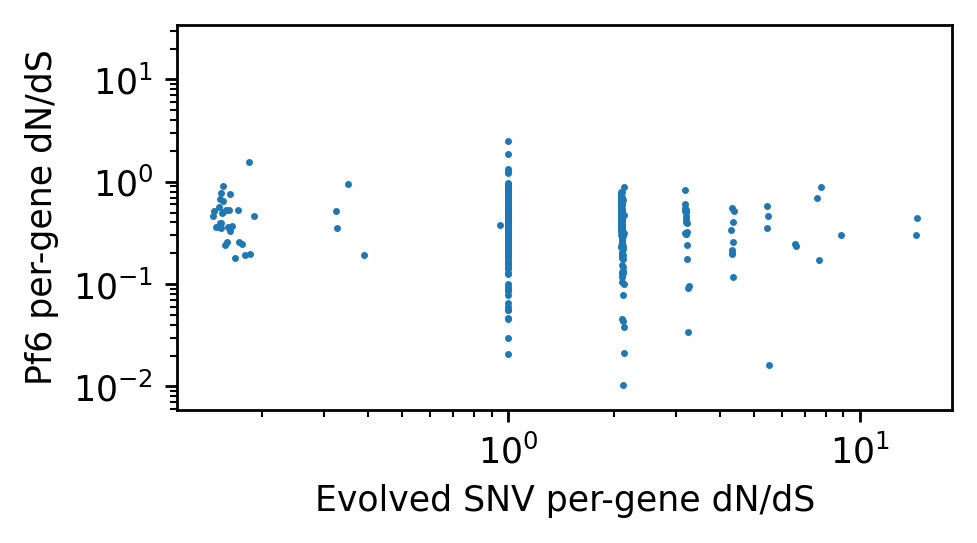

In [19]:
# dN/dS
fig, ax = plt.subplots(figsize=(4, 2))

evolved_dnds_list = []; pf6_dnds_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_dnds = evolved_gene_dnds_dict[gene] if gene in evolved_gene_dnds_dict else 0; evolved_dnds_list.append(evolved_dnds)
    pf6_dnds = gene_dnds_dict[gene] if gene in gene_dnds_dict else 0; pf6_dnds_list.append(pf6_dnds)
    ordered_gene_list.append(gene)
ax.plot(evolved_dnds_list, pf6_dnds_list, '.', markersize=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Evolved SNV per-gene dN/dS")
ax.set_ylabel("Pf6 per-gene dN/dS")

Text(0, 0.5, 'Pf6 per-gene dN')

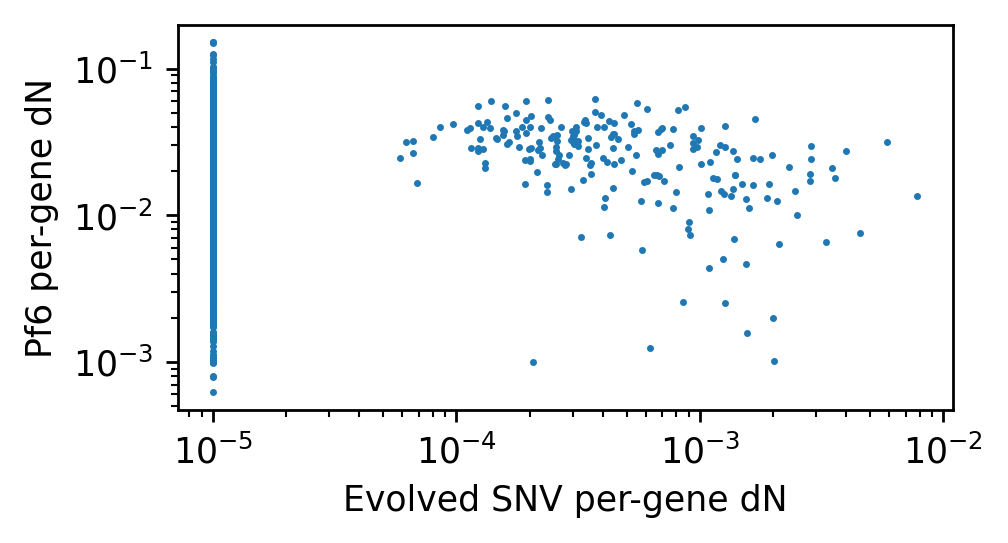

In [21]:
# dN

fig, ax = plt.subplots(figsize=(4, 2))

evolved_dn_list = []; pf6_dn_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_dn = evolved_gene_dn_dict[gene] if gene in evolved_gene_dn_dict else 1e-5; evolved_dn_list.append(evolved_dn)
    pf6_dn = gene_dn_dict[gene] if gene in gene_dn_dict else 1e-3; pf6_dn_list.append(pf6_dn)
    ordered_gene_list.append(gene)
ax.plot(evolved_dn_list, pf6_dn_list, '.', markersize=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Evolved SNV per-gene dN")
ax.set_ylabel("Pf6 per-gene dN")

Text(0, 0.5, 'Pf6 per-gene dS')

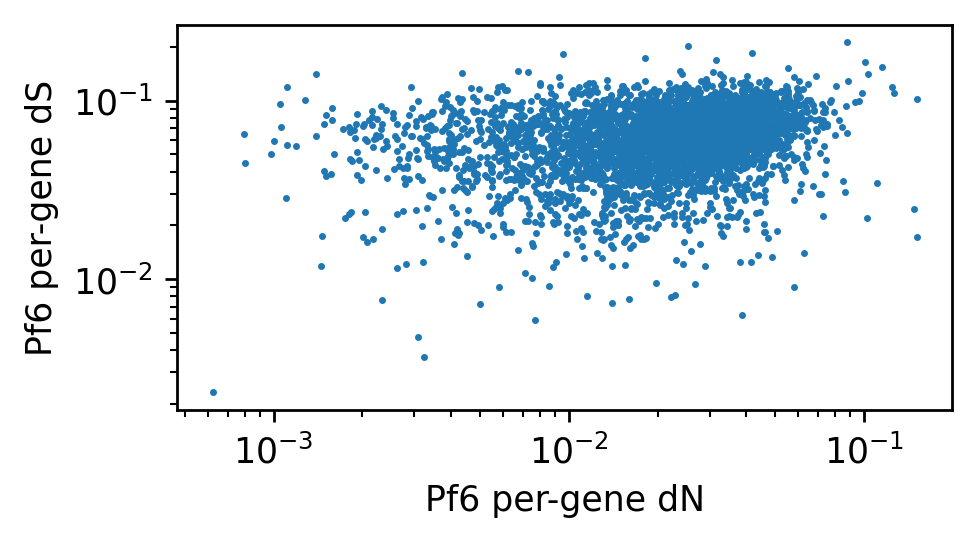

In [22]:
# dN vs dS

fig, ax = plt.subplots(figsize=(4, 2))

x_list = []; y_list = []
for gene in all_genes:
    if gene not in evolved_gene_dn_dict and gene in gene_dn_dict:
        pf6_dn = gene_dn_dict[gene]; x_list.append(pf6_dn)
        pf6_ds = gene_ds_dict[gene]; y_list.append(pf6_ds)
        # dnds = gene_dnds_dict[gene]; y_list.append(dnds)

ax.plot(x_list, y_list, '.', markersize=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Pf6 per-gene dN")
ax.set_ylabel("Pf6 per-gene dS")

Text(0, 0.5, 'Pf6 per-gene dS')

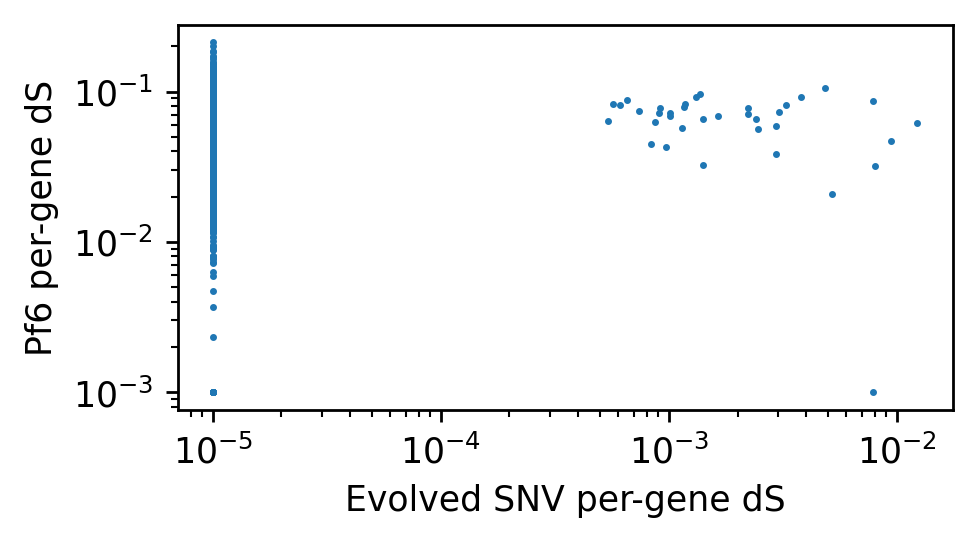

In [24]:
# dS

fig, ax = plt.subplots(figsize=(4, 2))

evolved_ds_list = []; pf6_ds_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_ds = evolved_gene_ds_dict[gene] if gene in evolved_gene_ds_dict else 1e-5; evolved_ds_list.append(evolved_ds)
    pf6_ds = gene_ds_dict[gene] if gene in gene_ds_dict else 1e-3; pf6_ds_list.append(pf6_ds)
    ordered_gene_list.append(gene)
ax.plot(evolved_ds_list, pf6_ds_list, '.', markersize=2)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Evolved SNV per-gene dS")
ax.set_ylabel("Pf6 per-gene dS")

In [41]:
for gene in ordered_gene_list:
    if gene in evolved_gene_dnds_dict and gene not in gene_dnds_dict:
        print(gene, gene_desc_dict[gene])

PF3D7_0115000 surface-associated interspersed protein 1.3 (SURFIN 1.3)
PF3D7_0222100 Pfmc-2TM Maurer's cleft two transmembrane protein


In [93]:
[evolved_gene_dn_dict[g] if g in evolved_nonsingleton_genes else -1 for g in ordered_gene_list].count(-1)

4814

In [103]:
len(set(ordered_gene_list).intersection(set(evolved_nonsingleton_genes)))    

127

# Continue here

In [21]:
import plotly.express as px

ordered_gene_list = sorted(all_genes)

# Remove genes that have no mutations in Pf6
ordered_gene_list.remove('PF3D7_0115000')
ordered_gene_list.remove('PF3D7_0222100')

evolved_dn_list = [evolved_gene_dn_dict[g] if g in evolved_nonsingleton_genes else -1 for g in ordered_gene_list]
evolved_ds_list = [evolved_gene_ds_dict[g] if g in evolved_nonsingleton_genes else -1 for g in ordered_gene_list]
evolved_dnds_list = [evolved_gene_dnds_dict[g] if g in evolved_nonsingleton_genes else -1 for g in ordered_gene_list]

pf6_dn_list = [gene_dn_dict[g] if g in gene_dn_dict else -1 for g in ordered_gene_list]
pf6_ds_list = [gene_ds_dict[g] if g in gene_ds_dict else -1 for g in ordered_gene_list]
pf6_dnds_list = [gene_dnds_dict[g] if g in gene_dnds_dict else -1 for g in ordered_gene_list]

evolved_ns_list = [evolved_gene_ns_count_dict[g] if g in evolved_gene_ns_count_dict else 0 for g in ordered_gene_list]
evolved_snv_list = [evolved_gene_snv_count_dict[g] if g in evolved_gene_snv_count_dict else 0 for g in ordered_gene_list]
pf6_ns_list = [gene_ns_count_dict[g] if g in gene_ns_count_dict else 0 for g in ordered_gene_list]
pf6_snv_list = [gene_snv_count_dict[g] if g in gene_snv_count_dict else 0 for g in ordered_gene_list]

df = pd.DataFrame(list(zip(ordered_gene_list,
                           [gene_name_dict[g] if g in gene_name_dict else '' for g in ordered_gene_list],
                           [gene_desc_dict[g].strip('"""') if g in gene_desc_dict else g for g in ordered_gene_list],
                           evolved_dn_list, pf6_dn_list, 
                           evolved_ds_list, pf6_ds_list,
                           evolved_dnds_list, pf6_dnds_list,
                           evolved_ns_list, evolved_snv_list,
                           pf6_ns_list, pf6_snv_list)), 
                  columns=['gene_ID', 'gene_name', 'gene_desc', 'evolved_dN', 'pf6_dN', 'evolved_dS', 'pf6_dS',
                           'evolved_dNdS', 'pf6_dNdS', 'evolved_NS', 'evolved_total',
                           'pf6_NS', 'pf6_total'])

df.to_csv('/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/evolved_vs_pf6_dNdS.tsv',sep='\t',index=False,header=True)

In [22]:
len(ordered_gene_list)

4941

# Supplemental Table 6

- Remove singletons in Pf6
- 3D plot add dN/dS as a third dimension
- Focus on SNPs in Pf6
- Reduce the clump on the left, maybe make a second plot

In [45]:
fig = px.scatter(df[df['evolved_dN'] == -1], x="pf6_dS", y="pf6_dN", size="pf6_total",
                 color='pf6_dNdS',
                 hover_data=['gene_desc', 'gene_ID', 'evolved_NS', 'evolved_total', 'pf6_NS', 'pf6_total'], 
                 log_x=True, log_y=True)

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

In [75]:
df[df['gene_ID'] == 'PF3D7_0304600']

gene_ID gene_name                      gene_desc  evolved_dN  \
327  PF3D7_0304600       CSP  circumsporozoite (CS) protein        -1.0   

       pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  evolved_NS  \
327  0.054507        -1.0  0.120833          -1.0  0.455293           0   

     evolved_total  pf6_NS  pf6_total  
327              0      52         81

In [76]:
df[df['gene_ID'] == 'PF3D7_0206800']

gene_ID gene_name                    gene_desc  evolved_dN  \
155  PF3D7_0206800      MSP2  merozoite surface protein 2        -1.0   

       pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  evolved_NS  \
155  0.102148        -1.0  0.021898          -1.0  4.448336           0   

     evolved_total  pf6_NS  pf6_total  
155              0      65         69

In [77]:
df[df['gene_ID'] == 'PF3D7_1133400']

gene_ID gene_name                  gene_desc  evolved_dN  \
2886  PF3D7_1133400      AMA1  apical membrane antigen 1        -1.0   

        pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  evolved_NS  \
2886  0.072512        -1.0  0.022727          -1.0   3.13502           0   

      evolved_total  pf6_NS  pf6_total  
2886              0     110        118

In [78]:
df[df['gene_ID'] == 'PF3D7_1216600']

gene_ID gene_name  \
3189  PF3D7_1216600    CelTOS   

                                              gene_desc  evolved_dN    pf6_dN  \
3189  cell traversal protein for ookinetes and sporo...        -1.0  0.110855   

      evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  evolved_NS  evolved_total  \
3189        -1.0  0.034483          -1.0  3.091264           0              0   

      pf6_NS  pf6_total  
3189      48         52

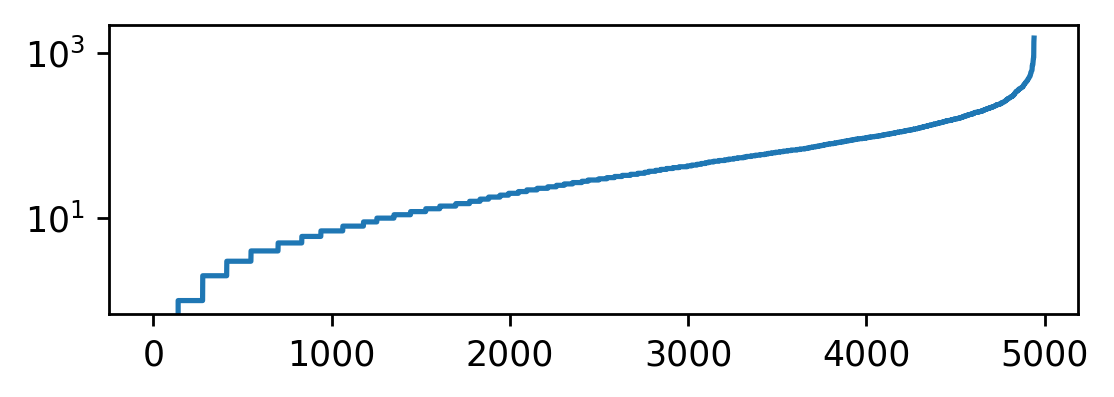

In [79]:
fig, ax = plt.subplots(figsize=(5, 1.5))
ax.plot(sorted(df['pf6_NS']))
ax.set_yscale('log')

In [48]:
for gene in gene_name_dict:
    if gene_name_dict[gene] in ['GI', 'CTRP', 'TLP1', 'TRAPPC5', 'PPKL', 'Trx-Px2', 'CSP', 'AMA1', 'CelTOS', 'MSP2']:
        print(gene, gene_name_dict[gene], gene_desc_dict[gene])

PF3D7_0206800 MSP2 merozoite surface protein 2
PF3D7_0304600 CSP circumsporozoite (CS) protein
PF3D7_0315200 CTRP circumsporozoite- and TRAP-related protein
PF3D7_1133400 AMA1 apical membrane antigen 1
PF3D7_1215000 Trx-Px2 thioredoxin peroxidase 2
PF3D7_1216600 CelTOS cell traversal protein for ookinetes and sporozoites
PF3D7_1437800 TRAPPC5 """trafficking protein particle complex subunit 5, putative"""
PF3D7_1462000 TLP1 thioredoxin-like protein
PF3D7_1466100 PPKL protein phosphatase containing kelch-like domains


In [80]:
for gene in gene_name_dict:
    for keyword in ['beta']:
        if keyword in gene_desc_dict[gene]:
            print(gene, gene_name_dict[gene], gene_desc_dict[gene])

PF3D7_0211400 KASIII beta-ketoacyl-ACP synthase III
PF3D7_0306800 CCT2 T-complex protein 1 subunit beta
PF3D7_0312400 GSK3beta glycogen synthase kinase-3 beta
PF3D7_0322100 Prt1 mRNA-capping enzyme subunit beta
PF3D7_0504600 BCKDHB """2-oxoisovalerate dehydrogenase subunit beta, mitochondrial, putative"""
PF3D7_0509800 PI4KB phosphatidylinositol 4-kinase beta
PF3D7_0517600 CPbeta """F-actin-capping protein subunit beta, putative"""
PF3D7_0524000 KASbeta karyopherin beta
PF3D7_0731800 GEXP08 """alpha/beta hydrolase, putative"""
PF3D7_0802600 ACbeta adenylyl cyclase beta
PF3D7_0821800 SEC61B """protein transport protein SEC61 subunit beta, putative"""
PF3D7_0905900 SEC27 """coatomer subunit beta, putative"""
PF3D7_0913200 EF-1beta elongation factor 1-beta
PF3D7_0933600 QCR1 """mitochondrial-processing peptidase subunit beta, putative"""
PF3D7_1002400 TRA2B """transformer-2 protein homolog beta, putative"""
PF3D7_1010600 eIF2beta eukaryotic translation initiation factor 2 subunit beta
PF3

In [53]:
df[df['gene_ID'] == 'PF3D7_0818900']

evolved_dN   pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  \
1736    0.000625  0.00125         0.0  0.085188      2.135757  0.021002   

      evolved_NS  evolved_total  pf6_NS  pf6_total        gene_ID  \
1736           1              1       2         39  PF3D7_0818900   

                          gene_desc  
1736  heat shock protein 70 (HSP70)

In [54]:
df[df['gene_ID'] == 'PF3D7_1451100']

evolved_dN    pf6_dN  evolved_dS   pf6_dS  evolved_dNdS  pf6_dNdS  \
4671    0.002017  0.001009         0.0  0.08909      5.520847  0.016251   

      evolved_NS  evolved_total  pf6_NS  pf6_total        gene_ID  \
4671           4              4       2         48  PF3D7_1451100   

                gene_desc  
4671  elongation factor 2

In [62]:
df[df['gene_ID'] == 'PF3D7_1328100']

evolved_dN   pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  \
3792     0.00156  0.00156         0.0  0.075581      2.134165  0.038146   

      evolved_NS  evolved_total  pf6_NS  pf6_total        gene_ID  \
3792           1              1       1         14  PF3D7_1328100   

                                     gene_desc  
3792  proteasome subunit beta type-7, putative

In [63]:
df[df['gene_ID'] == 'PF3D7_1472000']

evolved_dN    pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  \
4879    0.001996  0.001996         0.0  0.028571       2.10479  0.125179   

      evolved_NS  evolved_total  pf6_NS  pf6_total        gene_ID  \
4879           1              1       1          4  PF3D7_1472000   

                                    gene_desc  
4879  pre-mRNA-splicing factor ISY1, putative

In [32]:
df[df['gene_ID'] == 'PF3D7_1241700']

gene_ID gene_name                                 gene_desc  \
3419  PF3D7_1241700      RFC4  replication factor C subunit 4, putative   

      evolved_dN    pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  \
3419    0.001246  0.004985         0.0  0.076677      2.130037  0.078277   

      evolved_NS  evolved_total  pf6_NS  pf6_total  
3419           1              1       4         20

In [48]:
df_subset = df[df['evolved_dN'] == -1]
pf6_ds_list = df_subset["pf6_dS"]
pf6_dn_list = df_subset["pf6_dN"]
gene_ID_list = df_subset['gene_ID']

highlight_labels = ['CelTOS', 'MSP2', 'AMA1', 'GEST', 'MSP4', 'DBLMSP2', 'CSP', 'MTRAP', 'TREP', 'RH5', 'MSP9',
                   'TLP1', 'thioredoxin', 'MDR5', 'ferredoxin', 'K13', 'GCH1', 'MSRP4', 'TopoI', 'DHPS', 'PPKL']

gene_label_list = []
for gene in gene_ID_list:
    if gene == 'PF3D7_1451100':
        print(gene)
    label = ''
    if gene in gene_name_dict:
        label = gene_name_dict[gene]
    gene_label_list.append(label)

f = open("/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/Pf6_SNV_dN_vs_dS.tsv", 'w')
header_items = ['Gene ID', 'Gene', 'Pf6_dS', 'Pf6_dN', 'Pf6_dN_highlight',
                'Gene description', 'Old gene description']
f.write('\t'.join(header_items) + '\n')

gene_count = 0
any_gene_count = 0
for gene_ID, label, pf6_dN, pf6_dS in zip(gene_ID_list, gene_label_list, pf6_dn_list, pf6_ds_list):
    if pf6_dN != 0 and pf6_dS != 0:
        gene_count += 1
    if pf6_dN != 0 or pf6_dS != 0:
        any_gene_count += 1
    old_desc = big_gene_desc_dict[gene_ID] if gene_ID in big_gene_desc_dict else ''
    highlight = pf6_dN if label in highlight_labels else ''
    items = [gene_ID, label, pf6_dS, pf6_dN, highlight, gene_desc_dict[gene_ID], old_desc]
    f.write('\t'.join([str(item) for item in items]) + '\n')
f.close()
print("%i genes with SNVs in Pf6, %i genes plotted" % (any_gene_count, gene_count))

4828 genes with SNVs in Pf6, 4678 genes plotted


In [49]:
df_subset = df[df['evolved_dN'] != -1]
pf6_dn_list = df_subset["pf6_dN"]
evolved_dn_list = df_subset["evolved_dN"]
gene_ID_list = df_subset['gene_ID']

highlight_labels = ['ABCI3', 'MRP2', 'AsnRS', 'CRK5', 'TyrRS', 'HSP70', 'NDH2', 'RPN12', 'ACS11', 'SNRPD1', 'PARE', 
                    'DHODH', 'RPL17', 'AAT1', 'MDR1', 'ATP4', 'CRT', 'cPheRS', 'MFR3', 'PI4KB', 'cyto-IRS', 'ACAS', 
                    'ZIP1', 'PRS', 'GGPPS', 'AP2-G', 'CARL', 'MRSapi', 'eEF2', 'ISY1']

gene_label_list = []
for gene in gene_ID_list:
    label = ''
    if gene in gene_name_dict:
        label = gene_name_dict[gene]
    gene_label_list.append(label)

f = open("/storage/NFS/ANALYSIS/DNAseq/PfResistome_2023/daisy_test/Pf6_vs_evolved_SNV_dN.tsv", 'w')
header_items = ['Gene ID', 'Gene', 'Evolved_dN', 'Pf6_dN', 'Pf6_dN_highlight',
                'Gene description', 'Old gene description']
f.write('\t'.join(header_items) + '\n')
for gene_ID, label, pf6_dN, evolved_dN in zip(gene_ID_list, gene_label_list, pf6_dn_list, evolved_dn_list):
    old_desc = big_gene_desc_dict[gene_ID] if gene_ID in big_gene_desc_dict else ''
    highlight = pf6_dN if label in highlight_labels else ''
    items = [gene_ID, label, evolved_dN, pf6_dN, highlight, gene_desc_dict[gene_ID], old_desc]
    f.write('\t'.join([str(item) for item in items]) + '\n')
f.close()

In [46]:
fig = px.scatter(df[df['evolved_dN'] != -1], x="evolved_dN", y="pf6_dN", size="evolved_total",
                 color='pf6_dNdS', 
                 hover_data=['gene_desc', 'gene_ID', 'evolved_NS', 'evolved_total', 'pf6_NS', 'pf6_total'], 
                 log_x=True, log_y=True)

fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()
fig.write_html("Pf6_vs_evolved_SNV_dN.html")

In [38]:
df[df['gene_ID'] == 'PF3D7_1470900']

evolved_dN   pf6_dN  evolved_dS    pf6_dS  evolved_dNdS  pf6_dNdS  \
4868    0.002107  0.00632         0.0  0.035294      2.119382  0.220633   

      evolved_NS  evolved_total  pf6_NS  pf6_total        gene_ID  \
4868           1              1       3          7  PF3D7_1470900   

                                     gene_desc  
4868  proteasome subunit beta type-2, putative

In [108]:
len(df[(df['evolved_dN'] == -1) & (df['pf6_dN'] != 0) & (df['pf6_dS'] != 0)])

4659

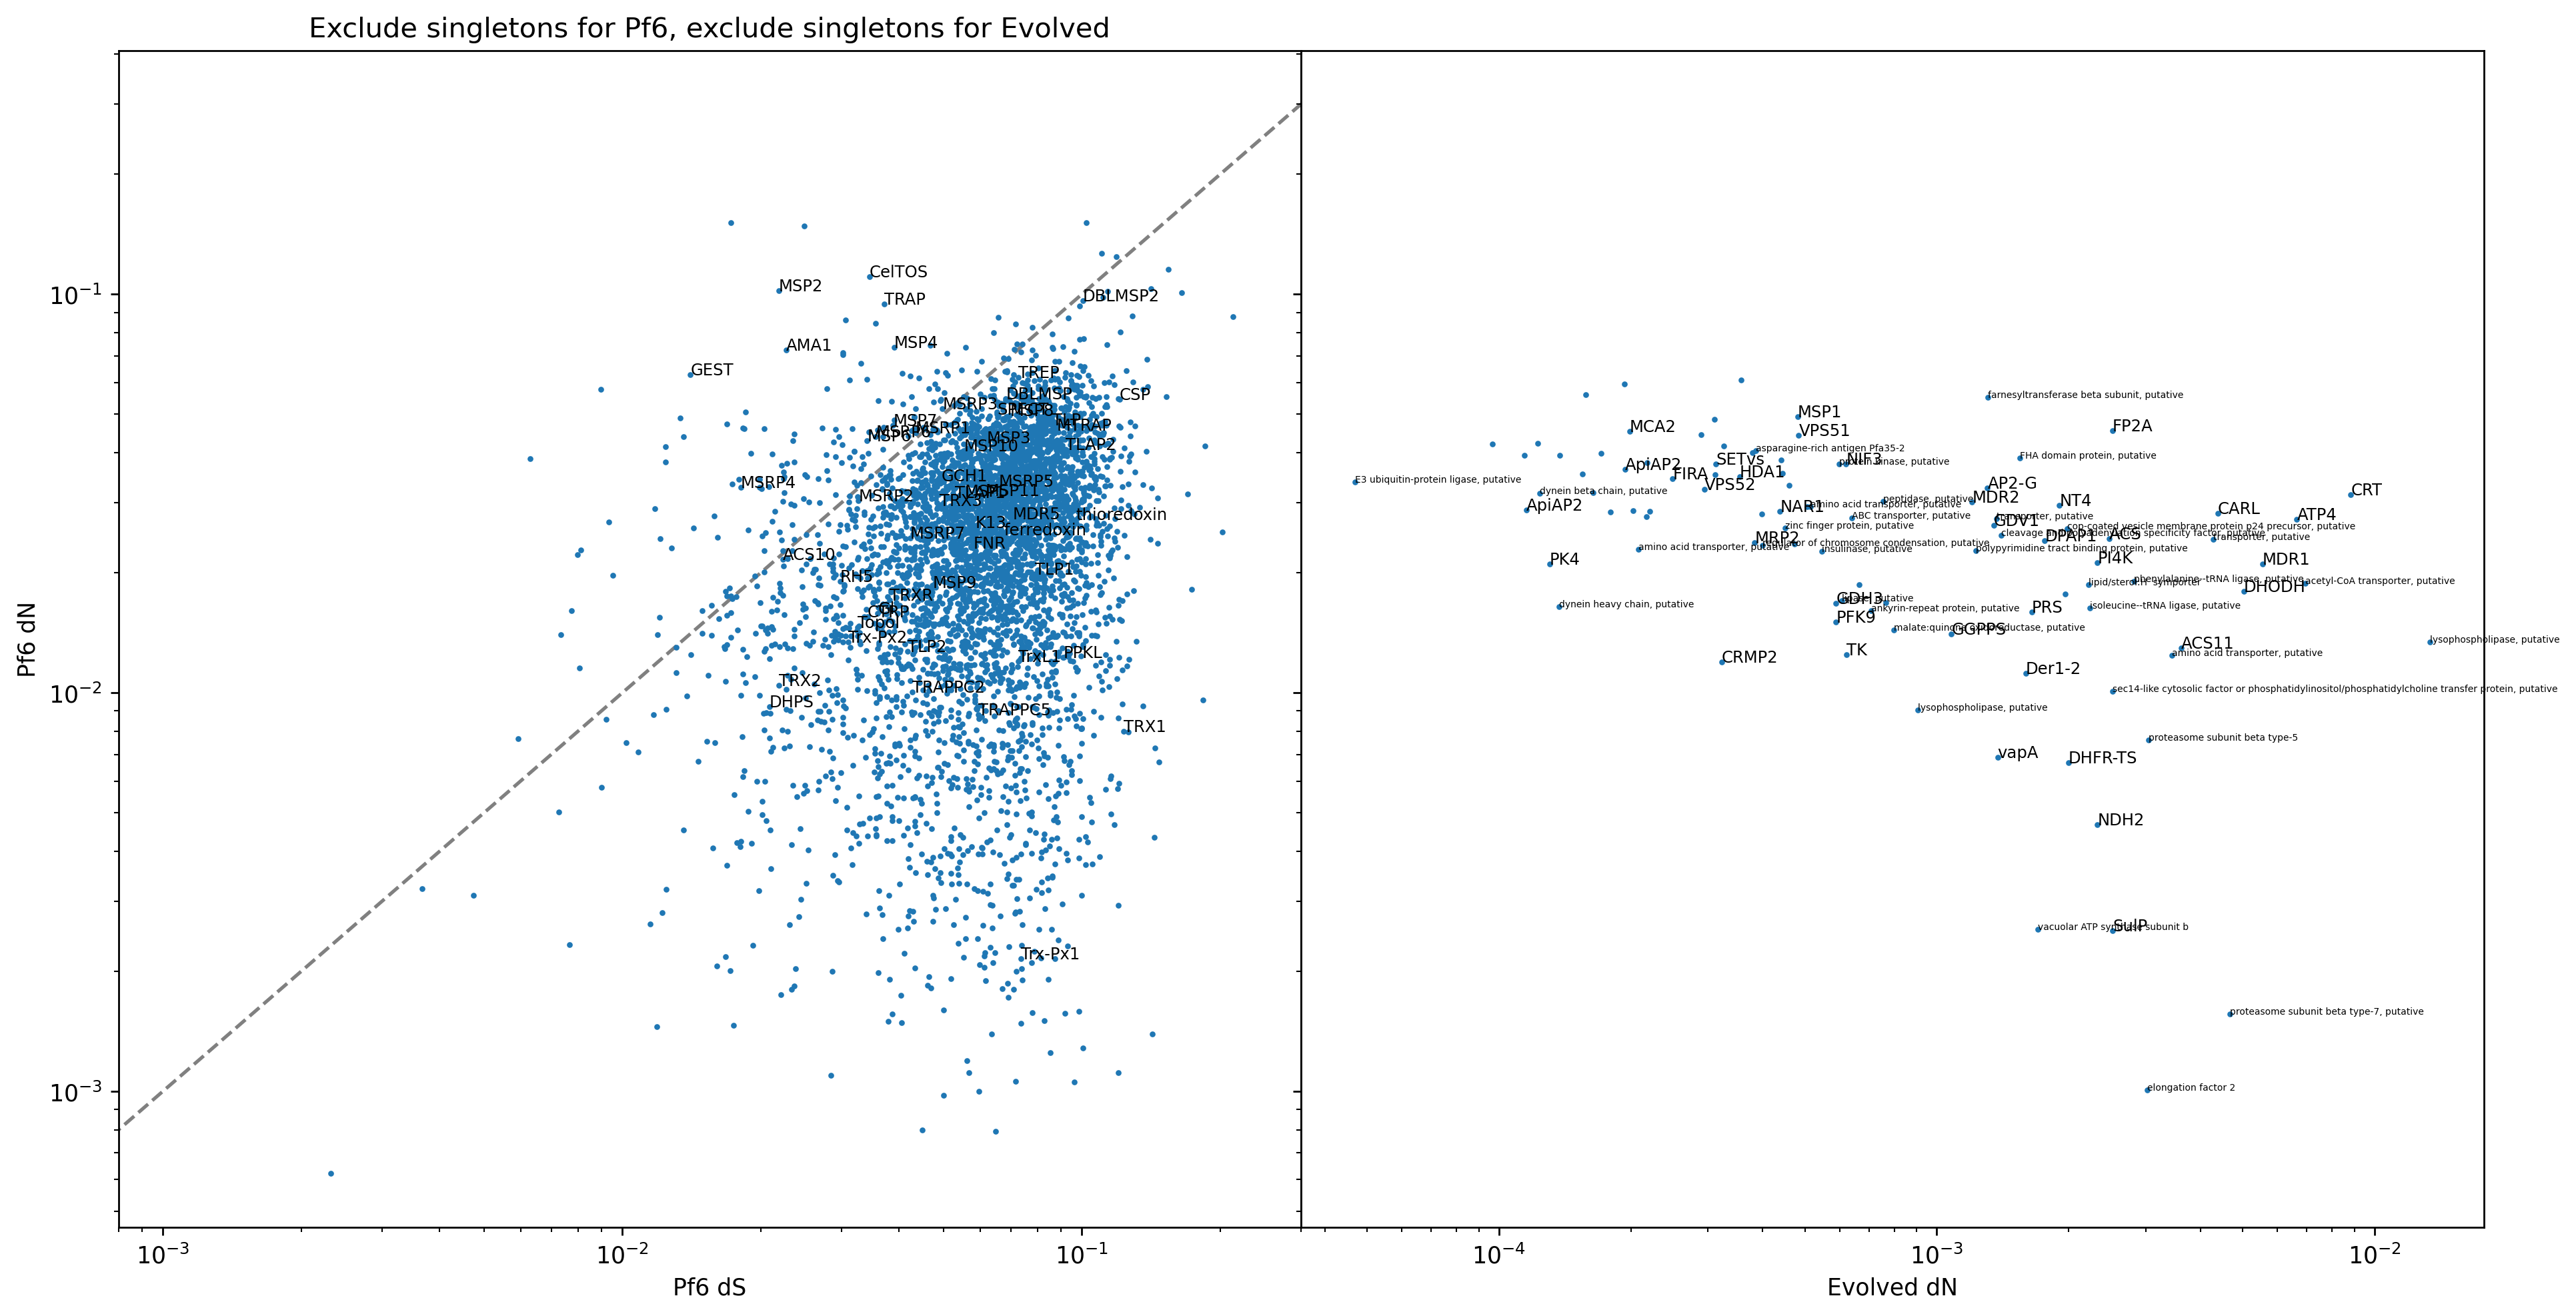

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

ax[0].plot([0, 0.3], [0, 0.3], '--', color='gray')
ax[0].set_xlim((0.8e-3, 0.3))

df_subset = df[df['evolved_dN'] == -1]
ax[0].plot(df_subset["pf6_dS"], df_subset["pf6_dN"], '.', markersize=3)
label_list = df_subset['gene_ID']
for x, y, gene in zip(df_subset["pf6_dS"], df_subset["pf6_dN"], label_list):
    if x == 0 or y == 0:
        continue
    if gene in big_gene_abbr_dict and interesting_gene(big_gene_desc_dict[gene]):
        ax[0].text(x, y, big_gene_abbr_dict[gene], fontsize=7)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel("Pf6 dN")
ax[0].set_xlabel("Pf6 dS")

df_subset = df[df['evolved_dN'] != -1]
ax[1].plot(df_subset["evolved_dN"], df_subset["pf6_dN"], '.', markersize=3)
label_list = df_subset['gene_ID']
for x, y, gene in zip(df_subset["evolved_dN"], df_subset["pf6_dN"], label_list):
    if x == 0 or y == 0:
        continue
    if gene in big_gene_abbr_dict: # and interesting_gene(big_gene_desc_dict[gene]):
        ax[1].text(x, y, big_gene_abbr_dict[gene], fontsize=7)
    elif 'unknown function' not in big_gene_desc_dict[gene]:
        ax[1].text(x, y, big_gene_desc_dict[gene], fontsize=4)
ax[1].set_xscale('log')
ax[1].set_xlabel("Evolved dN")

ax[0].set_title("Exclude singletons for Pf6, exclude singletons for Evolved")

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [41]:
fig = px.scatter_3d(df, x="evolved_dN", y="pf6_dN", z="pf6_dNdS", size="evolved_NS",
                 color='evolved_dNdS', 
                 hover_data=['gene_desc', 'evolved_NS', 'evolved_total', 'pf6_NS', 'pf6_total'], log_x=True)
fig.update_xaxes(range=[1e-7, 1])
fig.update_yaxes(range=[1e-7, 1])

fig.show()

In [37]:
fig = px.scatter_3d(df, x="evolved_dN", y="pf6_dN", z="pf6_dNdS", size="evolved_NS",
                 color='evolved_dNdS', 
                 hover_data=['gene_desc', 'evolved_NS', 'evolved_total', 'pf6_NS', 'pf6_total'], 
                 log_x=True, log_y=True, log_z=True)
fig.update_xaxes(range=[1e-6, 1])
fig.update_yaxes(range=[0.9e-5, 1])
fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()
# fig.write_html("Pf6_vs_evolved_SNV_dN.html")

Text(0, 0.5, 'Pf6 # missense SNVs per gene')

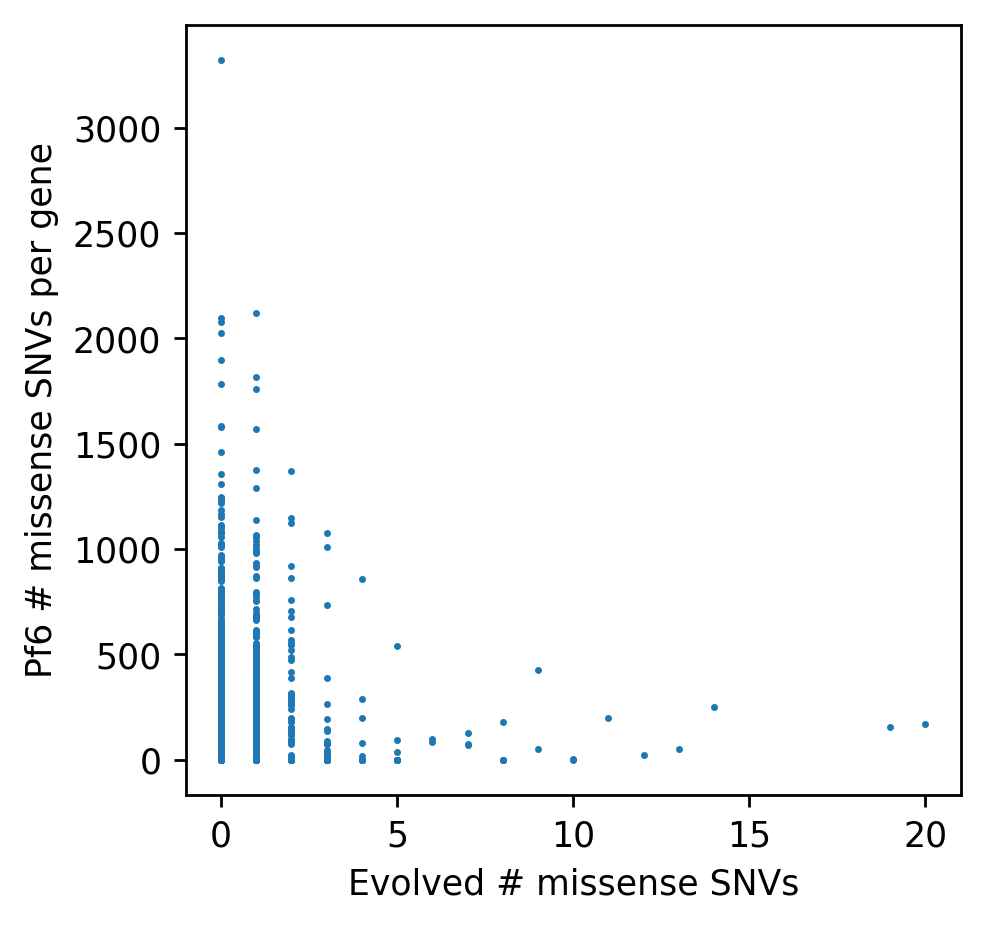

In [136]:
# Absolute numbers of SNVs

fig, ax = plt.subplots(figsize=(4, 4))

evolved_list = []; pf6_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_list.append(evolved_gene_ns_count_dict[gene] if gene in evolved_gene_ns_count_dict else 0)
    pf6_list.append(gene_ns_count_dict[gene] if gene in gene_ns_count_dict else 0)
    ordered_gene_list.append(gene)

ax.plot(evolved_list, pf6_list, '.', markersize=2)

ax.set_xlabel("Evolved # missense SNVs")
ax.set_ylabel("Pf6 # missense SNVs per gene")

Text(0, 0.5, 'Pf6 # SNVs per gene')

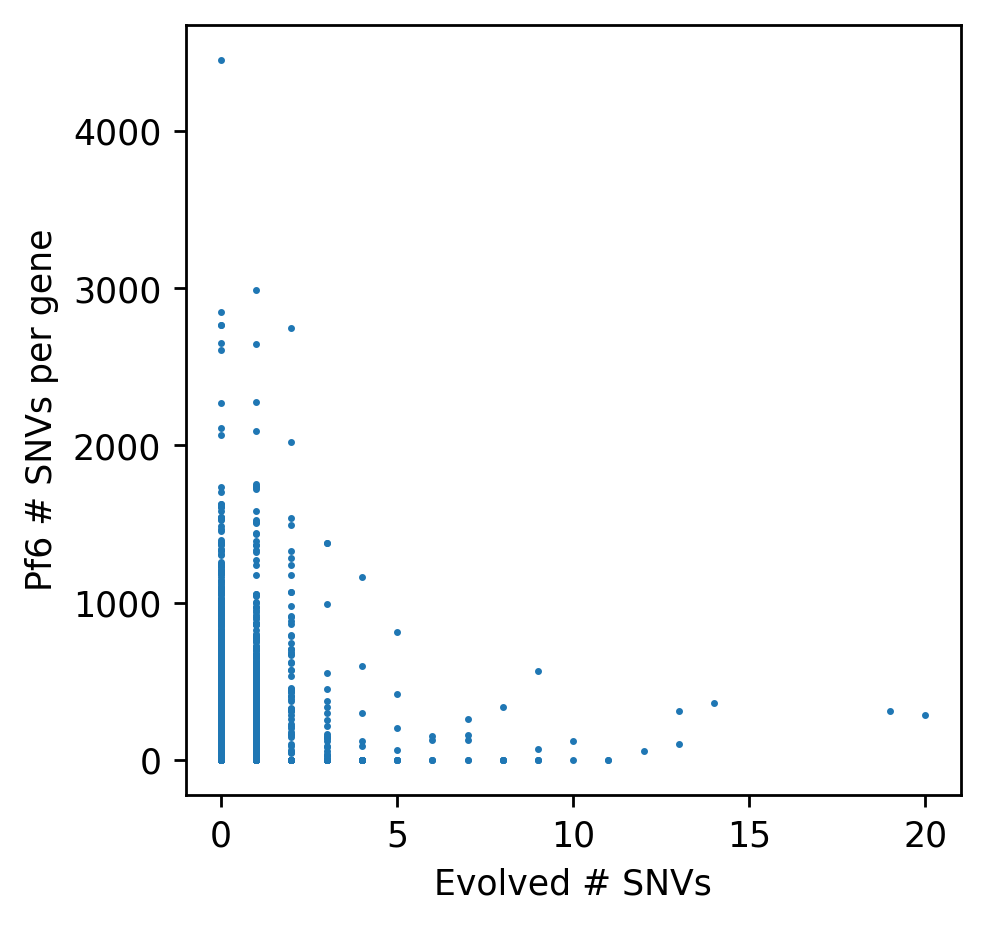

In [138]:
# Absolute numbers of SNVs

fig, ax = plt.subplots(figsize=(4, 4))

evolved_list = []; pf6_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_list.append(evolved_gene_snv_count_dict[gene] if gene in evolved_gene_snv_count_dict else 0)
    pf6_list.append(gene_snv_count_dict[gene] if gene in gene_snv_count_dict else 0)
    ordered_gene_list.append(gene)

ax.plot(evolved_list, pf6_list, '.', markersize=2)

ax.set_xlabel("Evolved # SNVs")
ax.set_ylabel("Pf6 # SNVs per gene")

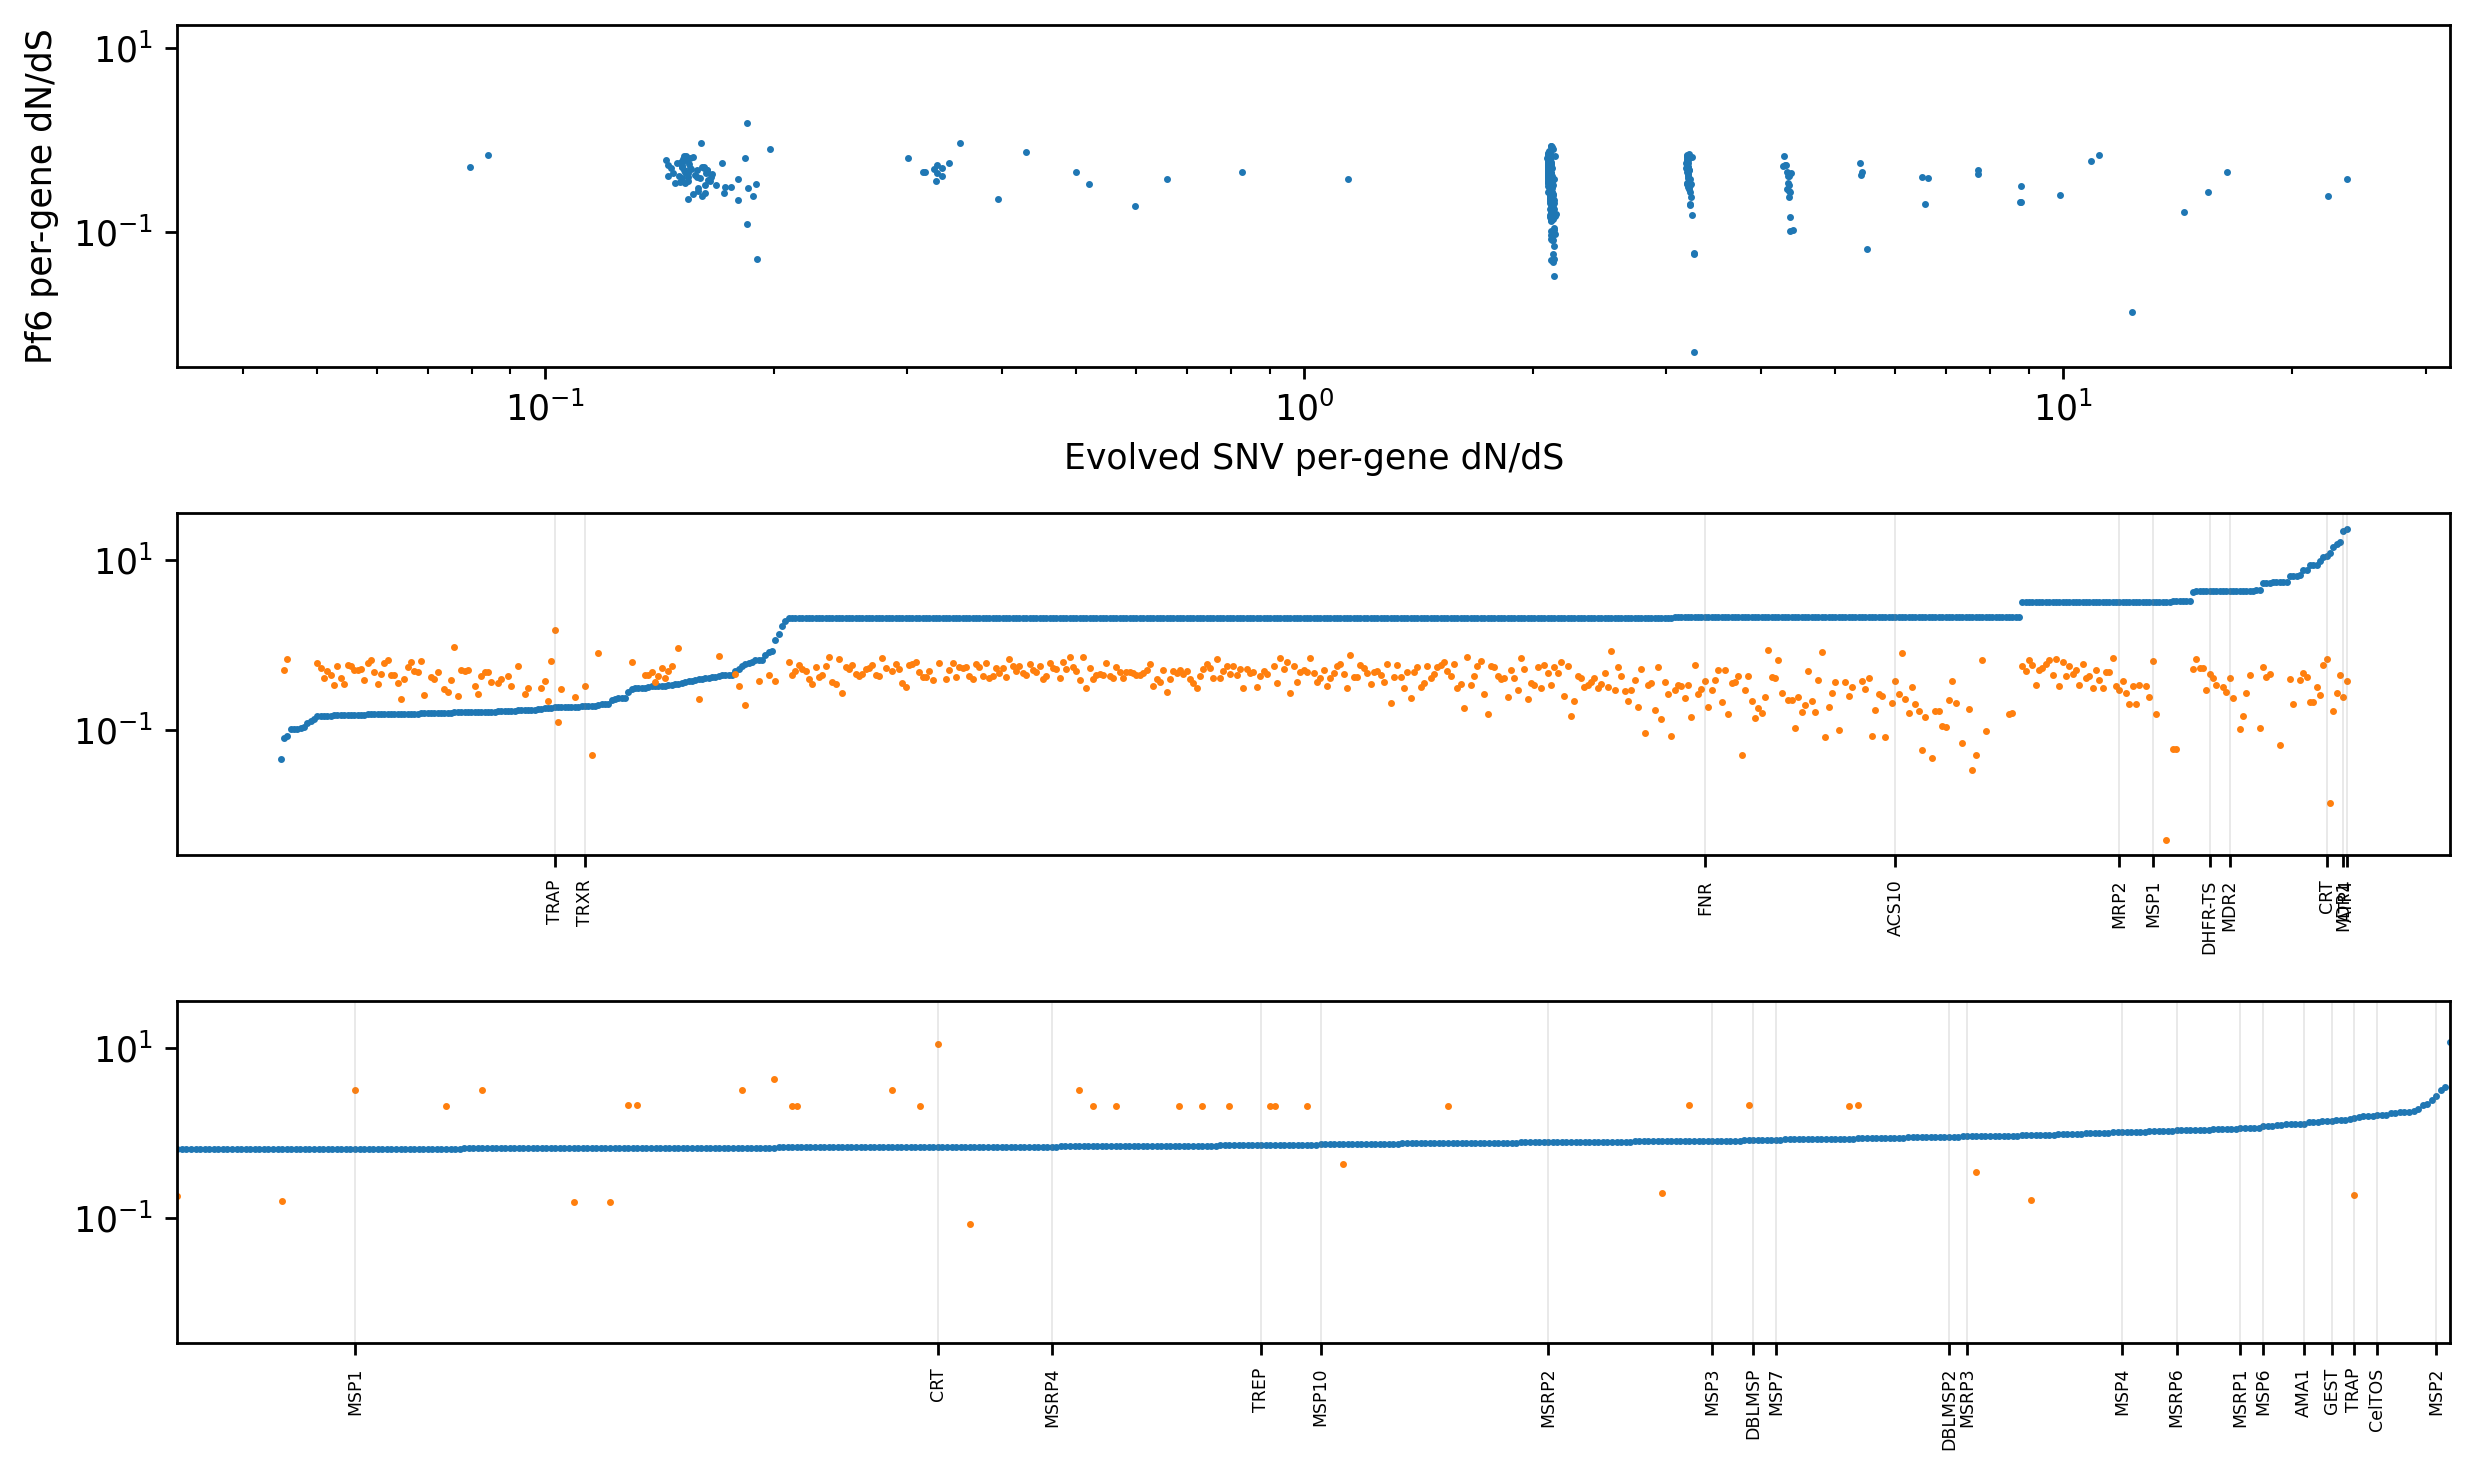

In [118]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

evolved_dnds_list = []; pf6_dnds_list = []; ordered_gene_list = []
for gene in all_genes:
    evolved_dnds = evolved_gene_dnds_dict[gene] if gene in evolved_gene_dnds_dict else 0; evolved_dnds_list.append(evolved_dnds)
    pf6_dnds = gene_dnds_dict[gene] if gene in gene_dnds_dict else 0; pf6_dnds_list.append(pf6_dnds)
    ordered_gene_list.append(gene)
ax[0].plot(evolved_dnds_list, pf6_dnds_list, '.', markersize=2)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("Evolved SNV per-gene dN/dS")
ax[0].set_ylabel("Pf6 per-gene dN/dS")

evolved_genes_sorted_by_dnds = [tup[0] for tup in sorted(evolved_gene_dnds_dict.items(), key=lambda x: x[1])]
xs = np.arange(len(evolved_genes_sorted_by_dnds))
ax[1].plot(xs, [evolved_gene_dnds_dict[g] for g in evolved_genes_sorted_by_dnds], '.', markersize=2)
ax[1].plot(xs, [gene_dnds_dict[g] if g in gene_dnds_dict else -1
                   for g in evolved_genes_sorted_by_dnds], '.', markersize=2)
ax[1].set_yscale('log')

ordered_interesting_gene_label_list = []
interesting_xs = []
for x, gene in zip(xs, evolved_genes_sorted_by_dnds):
    if gene in big_gene_abbr_dict:
        abbr = big_gene_abbr_dict[gene]
        if interesting_gene(big_gene_desc_dict[gene]):
            ordered_interesting_gene_label_list.append(abbr)
            ax[1].axvline(x=x, color='gray', linewidth=0.1)
            interesting_xs.append(x)

ax[1].set_xticks(interesting_xs)
ax[1].set_xticklabels(ordered_interesting_gene_label_list, fontsize=5, rotation=90)

pf6_genes_sorted_by_dnds = [tup[0] for tup in sorted(gene_dnds_dict.items(), key=lambda x: x[1])]
xs = np.arange(len(pf6_genes_sorted_by_dnds))
ax[2].plot(xs, [gene_dnds_dict[g] for g in pf6_genes_sorted_by_dnds], '.', markersize=2)
ax[2].plot(xs, [evolved_gene_dnds_dict[g] if g in evolved_gene_dnds_dict else -1
                   for g in pf6_genes_sorted_by_dnds], '.', markersize=2)
ax[2].set_yscale('log')

ordered_interesting_gene_label_list = []
interesting_xs = []
for x, gene in zip(xs, pf6_genes_sorted_by_dnds):
    if gene in big_gene_abbr_dict:
        abbr = big_gene_abbr_dict[gene]
        if interesting_gene(big_gene_desc_dict[gene]):
            ordered_interesting_gene_label_list.append(abbr)
            ax[2].axvline(x=x, color='gray', linewidth=0.1)
            interesting_xs.append(x)

ax[2].set_xticks(interesting_xs)
ax[2].set_xticklabels(ordered_interesting_gene_label_list, fontsize=5, rotation=90)
ax[2].set_xlim((xs[-500], xs[-1]))

plt.tight_layout()

In [15]:
gene_country_ns_snvs_dict = {}
gene_country_s_snvs_dict = {}

country_samples_dict = defaultdict(set)

for gene in tqdm(all_genes):   
    big_gene = gene.split('.')[0]
    
    if big_gene in gene_country_ns_snvs_dict: # Already there
        for sample in all_good_samples:
            country = sample_country_dict[sample]
            country_samples_dict[country].add(sample)
            if gene in sample_gene_ns_s_dict[sample]:
                ns_snvs, s_snvs = sample_gene_ns_s_dict[sample][gene]
                for snv in ns_snvs:
                    gene_country_ns_snvs_dict[big_gene][country][snv] += 1
                for snv in s_snvs:
                    gene_country_s_snvs_dict[big_gene][country][snv] += 1
    else:
        country_ns_snvs_dict = {c: defaultdict(int) for c in all_countries}
        country_s_snvs_dict = {c: defaultdict(int) for c in all_countries}
        for sample in all_good_samples:
            country = sample_country_dict[sample]
            country_samples_dict[country].add(sample)
            if gene in sample_gene_ns_s_dict[sample]:
                ns_snvs, s_snvs = sample_gene_ns_s_dict[sample][gene]                
                for snv in ns_snvs:
                    country_ns_snvs_dict[country][snv] += 1
                for snv in s_snvs:
                    country_s_snvs_dict[country][snv] += 1
        
        gene_country_ns_snvs_dict[big_gene] = country_ns_snvs_dict
        gene_country_s_snvs_dict[big_gene] = country_s_snvs_dict

NameError: name 'all_genes' is not defined

In [ ]:
# dN/dS per gene per country

gene_country_dnds_dict = defaultdict(dict)

for gene in gene_country_ns_snvs_dict:
    
    if gene not in big_gene_expn_exps_dict:
        continue
    
    for country in gene_country_ns_snvs_dict[gene]:
        ns_count = len(gene_country_ns_snvs_dict[gene][country])
        s_count = len(gene_country_s_snvs_dict[gene][country])
        
        expn, exps = big_gene_expn_exps_dict[gene]
        
        pseudo_dN = 1.0/(exps/2.0+expn)
        pseudo_dS = 1.0/(exps/2.0+expn)
        
        dNdS = (pseudo_dN + (ns_count/expn))/(pseudo_dS + (s_count/exps))
        
        gene_country_dnds_dict[gene][country] = (ns_count, s_count, expn, exps, dNdS)

In [75]:
data = '''id,full name,three letter code,single letter code,monoisotopic mass,average mass,composition
0,Glycine,Gly,G,57.021464,57.050000,C2H3NO
1,Alanine,Ala,A,71.037114,71.080000,C3H5NO
2,Serine,Ser,S,87.032029,87.080000,C3H5NO2
3,Proline,Pro,P,97.052764,97.120000,C5H7NO
4,Valine,Val,V,99.068414,99.130000,C5H9NO
5,Threonine,Thr,T,101.047680,101.110000,C4H7NO2
6,Cysteine,Cys,C,103.009190,103.140000,C3H5NOS
7,Leucine,Leu,L,113.084060,113.160000,C6H11NO
8,Isoleucine,Ile,I,113.084060,113.160000,C6H11NO
9,Asparagine,Asn,N,114.042930,114.100000,C4H6N2O2
10,Aspartic Acid,Asp,D,115.026940,115.090000,C4H5NO3
11,Glutamine,Gln,Q,128.058580,128.130000,C5H8N2O2
12,Lysine,Lys,K,128.094960,128.170000,C6H12N2O
13,Glutamic Acid,Glu,E,129.042590,129.120000,C5H7NO3
14,Methionine,Met,M,131.040480,131.200000,C5H9NOS
15,Histidine,His,H,137.058910,137.140000,C6H7N3O
16,Phenylalanine,Phe,F,147.068410,147.180000,C9H9NO
17,Arginine,Arg,R,156.101110,156.190000,C6H12N4O
18,Tyrosine,Tyr,Y,163.063330,163.170000,C9H9NO2
19,Tryptophan,Trp,W,186.079310,186.210000,C11H10N2O
128,Stop,[*],*,0.000000,0.000000,
129,Unknown,[X],X,0.000000,0.000000'''

aa_abbr3_dict = {}
aa_abbr1_dict = {}
for line in data.split('\n'):
    _, aa, abbr3, abbr1 = line.split(',')[:4]
    aa = aa.replace('ic Acid', 'ate')
    aa_abbr1_dict[aa] = abbr1
    aa_abbr3_dict[aa] = abbr3